In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
import sys
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns
import networkx as nx
from scipy.spatial import Delaunay
from tqdm import tqdm
from matplotlib.patches import Patch
from collections import Counter 
import seaborn as sns
from scipy.stats import zscore
from scipy.cluster import hierarchy
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
import pickle
import os 

## Load data

In [ ]:
annotation = pd.read_csv('../output/Scaled_data_121024/ROI.csv')

annotation.loc[annotation['Annotation'].str.contains('CD8'), 'Annotation'] = 'CD8 T'
annotation.loc[annotation['Annotation'].str.contains('CD4'), 'Annotation'] = 'CD4 T'
annotation.loc[annotation['Annotation'].str.contains('Tumor'), 'Annotation'] = 'Tumor'
annotation = annotation.loc[~annotation['Annotation'].isin(['Other', 'Neutrophil'])]
annotation = annotation.loc[~annotation['coreName'].str.contains('Tonsil')]

selected_cores =  ["Rochester_4", "Rochester_6",
                    "Rochester_7", "Rochester_9", "Rochester_11", "Rochester_12",
                    "Rochester_13", "Rochester_14",
                    "Rochester_15", "Rochester_16", "Rochester_17", "Rochester_18",
                    "Rochester_19", "Rochester_21", "Rochester_23", "Rochester_25",
                     "DFCI_2.2", "DFCI_3.2",
                    "DFCI_4.1", "DFCI_7.1", "DFCI_8.1",
                    "DFCI_12.1", "DFCI_13.2", "DFCI_14.1", "DFCI_15.2", "DFCI_17.1",
                    "DFCI_18.2", "DFCI_19.2", "DFCI_22.2", "DFCI_23.2"]

annotation = annotation.loc[annotation['coreName'].isin(selected_cores)]

annotation.loc[annotation['Annotation'].str.contains('M1'), 'Annotation'] = 'M1-like'
annotation.loc[annotation['Annotation'].str.contains('M2'), 'Annotation'] = 'M2-like'

In [3]:
annotation['ebv_status'] = annotation['coreName'].apply(lambda x: 'Positive' if x in ["DFCI_1.2", "DFCI_2.2", "DFCI_3.2",
                         "DFCI_4.1", "DFCI_6.1", "DFCI_7.1", "DFCI_8.1", "DFCI_9.1", "DFCI_11.1",
                         "DFCI_12.1", "Rochester_4", "Rochester_5","Rochester_7",
                         "Rochester_9", "Rochester_10","Rochester_14", "Rochester_11", "Rochester_15",
                         "Rochester_16", "Rochester_17", "Rochester_18",  "Rochester_25"
                         ] else 'Negative') 

In [34]:
annotation.groupby(['ebv_status', 'Annotation'])[['ebv_status', 'Annotation']].count()

ebv_status  Annotation
ebv_status Annotation                         
Negative   CD4 T              9819        9819
           CD8 T              9789        9789
           DC                 2904        2904
           Endothelial        2378        2378
           M1-like            2051        2051
           M2-like            2002        2002
           Treg                943         943
           Tumor             52770       52770
Positive   CD4 T             21585       21585
           CD8 T             21903       21903
           DC                 4774        4774
           Endothelial        5051        5051
           M1-like            2530        2530
           M2-like            6081        6081
           Treg               4479        4479
           Tumor             21958       21958

In [5]:
annotation[annotation['Annotation'] == 'M2-like'].groupby(['ebv_status', 'Annotation', 'coreName'])[['ebv_status', 'Annotation', 'coreName']].count()

ebv_status  Annotation  coreName
ebv_status Annotation coreName                                      
Negative   M2-like    DFCI_13.2            361         361       361
                      DFCI_14.1             67          67        67
                      DFCI_15.2             53          53        53
                      DFCI_17.1            329         329       329
                      DFCI_18.2             43          43        43
                      DFCI_19.2            123         123       123
                      DFCI_21.1             55          55        55
                      DFCI_22.2            128         128       128
                      DFCI_23.2             75          75        75
                      Rochester_12         415         415       415
                      Rochester_13          92          92        92
                      Rochester_19          10          10        10
                      Rochester_21         260         260       260
                      Rochester_23           4           4         4
                      Rochester_6           58          58        58
                      Rochester_8          564         564       564
Positive   M2-like    DFCI_1.2            1540        1540      1540
                      DFCI_11.1            293         293       293
                      DFCI_12.1            619         619       619
                      DFCI_2.2             166         166       166
                      DFCI_3.2             314         314       314
                      DFCI_4.1             153         153       153
                      DFCI_6.1             113         113       113
                      DFCI_7.1             420         420       420
                      DFCI_8.1              49          49        49
                      DFCI_9.1             191         191       191
                      Rochester_10         406         406       406
                      Rochester_11         798         798       798
                      Rochester_14         713         713       713
                      Rochester_15         691         691       691
                      Rochester_16         708         708       708
                      Rochester_17         486         486       486
                      Rochester_18          87          87        87
                      Rochester_25         445         445       445
                      Rochester_4           13          13        13
                      Rochester_5            5           5         5
                      Rochester_7          787         787       787
                      Rochester_9           77          77        77

## Color palette for cell type

In [4]:
celltype_color = {"Tumor" : "#e51d1d", 
                      "CD8 T" : "#377eb8", 
                      "CD4 T" : "#4eaf49", 
                      "M1-like" : "#974da2", 
                      "M2-like" : "#ff8000", 
                      "DC" : "#83e3f0", 
                      "Endothelial" : "#c67f66", 
                      "Treg" : "#9ED900", 
                      "B cell" : "#e89ff0",
                    "Other": "#D3D3D3E6",
                    "Neutrophil": "#C85022"}

In [6]:
# Function to get one-hop and two-hop neighbors for a given node
def get_neighbors(graph, node):
    # Get one-hop neighbors
    one_hop_neighbors = list(graph.neighbors(node))
    
    # Get two-hop neighbors
    two_hop_neighbors = set()
    for neighbor in one_hop_neighbors:
        two_hop_neighbors.update(graph.neighbors(neighbor))
    
    # Remove the original node and one-hop neighbors from the two-hop neighbors
    two_hop_neighbors.discard(node)
    two_hop_neighbors.difference_update(one_hop_neighbors)
    
    return one_hop_neighbors, list(two_hop_neighbors)

def within_threshold(p1, p2, mpp, threshold = 100):
    distance = np.linalg.norm(p1 - p2) * mpp
    return (distance <= threshold)

In [ ]:
graph_dict = {}

count_df_dict = {}

for core in tqdm(annotation['coreName'].unique()):
    print(f'Working on {core}...')

    # subset data
    sub_df = annotation.loc[annotation['coreName'] == core] 
    sub_df = sub_df.loc[~sub_df['Annotation'].isin(['Neutrophil', 'Other'])]
    pts = sub_df.loc[:,['X_cent', 'Y_cent']].values
    sub_df_reindex = sub_df.reset_index(drop = True)

    # Delaunay triangulation
    tri = Delaunay(points = pts)
    
    # Create a graph from the triangulation
    G = nx.Graph()
    G.add_nodes_from(range(len(pts)))
    MPP = 0.5 # micron per pixel
    THRESHOLD = 50 # only connect nodes if they are within 50um of each other 
    for simplex in tri.simplices:
        if within_threshold(pts[simplex[0]], pts[simplex[1]], mpp = MPP, threshold = THRESHOLD):
            G.add_edge(simplex[0], simplex[1])
        if within_threshold(pts[simplex[1]], pts[simplex[2]], mpp = MPP, threshold = THRESHOLD):
            G.add_edge(simplex[1], simplex[2])
        if within_threshold(pts[simplex[2]], pts[simplex[0]], mpp = MPP, threshold = THRESHOLD):
            G.add_edge(simplex[2], simplex[0])
    print(f'Nodes in Graph match rows in dataframe: {G.number_of_nodes() == sub_df.shape[0]}')

    # append graph to graph dict

    graph_dict[core] = G

    # Create a dict to store the 1-hop, 2-hop neighbors

    neighbors_dict = {}

    for node in G.nodes():
        neighbors_dict[node] = {}
        one_hop, two_hop = get_neighbors(G, node)
        neighbors_dict[node]['one hop'] = one_hop
        neighbors_dict[node]['two hop'] = two_hop

    cellLabel_neighbors_dict = {}

    for key, item in neighbors_dict.items():
        new_key = sub_df_reindex['cellLabel'][key]
        cellLabel_neighbors_dict[new_key] = {}
        one_hop_cellLabel = str(sub_df_reindex['cellLabel'][item['one hop']].values)
        two_hop_cellLabel = str(sub_df_reindex['cellLabel'][item['two hop']].values)
        cellLabel_neighbors_dict[new_key]['one hop'] = one_hop_cellLabel
        cellLabel_neighbors_dict[new_key]['two hop'] = two_hop_cellLabel


    LUT_df = pd.DataFrame([(key, item['one hop'], item['two hop']) for key, item in cellLabel_neighbors_dict.items()],
                                columns=['cellLabel', 'one_hop', 'two_hop'])
    
    output = '../output/hop_LUT'

    os.makedirs(output, exist_ok=True)

    LUT_df.to_csv(f'{output}/{core}.csv', index=False)

In [19]:
sub_df_reindex

,cellLabel,Y_cent,X_cent,coreName,Y_global,X_global,Annotation,cellSize,DAPI,CD20,...,RelB,CD68,CD163,BCL2,BCL6,Syto13,Tox,PD-L1,Myc,ebv_status
0,2274,957.684564,1698.984340,DFCI_4.1,30166.684564,5271.984340,CD8 T,447,100.460850,6.152125,...,13.827740,0.248322,0.322148,23.597315,9.973154,4476.496533,46.416089,144.517337,2.876560,Positive
1,2290,963.380952,1216.610390,DFCI_4.1,30172.380952,4789.610390,CD8 T,231,74.939394,0.108225,...,7.372294,0.580087,0.034632,5.909091,19.619048,3035.792453,49.584906,105.385445,2.838275,Positive
2,2375,976.094253,1589.262069,DFCI_4.1,30185.094253,5162.262069,CD8 T,435,100.248276,1.170115,...,6.328736,0.333333,0.022989,13.234483,9.241379,4201.074499,15.577364,47.405444,0.305158,Positive
3,2923,1067.034682,1216.427746,DFCI_4.1,30276.034682,4789.427746,CD8 T,173,57.115607,7.693642,...,8.560694,0.069364,0.000000,13.549133,19.710983,3204.748227,34.088652,55.446809,26.702128,Positive
4,2951,1074.949091,1170.312727,DFCI_4.1,30283.949091,4743.312727,CD8 T,275,136.727273,11.436364,...,12.189091,0.818182,0.000000,56.432727,21.854545,6809.896018,65.077434,114.367257,5.716814,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6752,15600,2414.179688,1656.359375,DFCI_4.1,31623.179688,5229.359375,Tumor,256,112.417969,13.097656,...,1.324219,1.125000,0.007812,7.921875,11.785156,5722.891827,43.557692,34.848558,3.125000,Positive
6753,15639,2416.457500,1201.737500,DFCI_4.1,31625.457500,4774.737500,Tumor,400,149.105000,18.587500,...,2.425000,1.282500,0.025000,35.027500,11.047500,6541.140406,47.656786,30.667707,6.541342,Positive
6754,15680,2418.579909,1581.228311,DFCI_4.1,31627.579909,5154.228311,Tumor,219,74.707763,11.077626,...,1.657534,0.187215,0.150685,2.342466,2.305936,3238.078873,26.371831,13.118310,0.676056,Positive
6755,15754,2425.015432,815.885802,DFCI_4.1,31634.015432,4388.885802,Tumor,324,69.944444,26.913580,...,0.759259,0.104938,0.000000,0.938272,4.861111,2682.477011,9.764368,21.593870,2.191571,Positive


In [8]:
graph_dict = {}

count_df_dict = {}

for core in tqdm(annotation['coreName'].unique()):
    print(f'Working on {core}...')
    # Create a new figure for each core
    fig, ax = plt.subplots(figsize=(20, 20))

    # subset data
    sub_df = annotation.loc[annotation['coreName'] == core] 
    sub_df = sub_df.loc[~sub_df['Annotation'].isin(['Neutrophil', 'Other'])]
    pts = sub_df.loc[:,['X_cent', 'Y_cent']].values
    sub_df_reindex = sub_df.reset_index(drop = True)

    # Delaunay triangulation
    tri = Delaunay(points = pts)
    
    # Create a graph from the triangulation
    G = nx.Graph()
    G.add_nodes_from(range(len(pts)))
    MPP = 0.5 # micron per pixel
    THRESHOLD = 20 # only connect nodes if they are within 50um of each other 
    for simplex in tri.simplices:
        if within_threshold(pts[simplex[0]], pts[simplex[1]], mpp = MPP, threshold = THRESHOLD):
            G.add_edge(simplex[0], simplex[1])
        if within_threshold(pts[simplex[1]], pts[simplex[2]], mpp = MPP, threshold = THRESHOLD):
            G.add_edge(simplex[1], simplex[2])
        if within_threshold(pts[simplex[2]], pts[simplex[0]], mpp = MPP, threshold = THRESHOLD):
            G.add_edge(simplex[2], simplex[0])
    print(f'Nodes in Graph match rows in dataframe: {G.number_of_nodes() == sub_df.shape[0]}')

    # append graph to graph dict

    graph_dict[core] = G

    # position of the nodes for plotting
    pos = dict(zip(range(len(pts)), pts))

    # Convert positions to a numpy array for easy transformation
    pos_array = np.array([coords for coords in pos.values()])

    # Reflect the graph about the x-axis (flip y-coordinates)
    reflected_array = pos_array * [1, -1]

    # Create a new position dictionary from the reflected array
    reflected_pos = dict(zip(pos.keys(), reflected_array))

    output = '../output/hop_analysis_121024/graph_20um_ROI'

    os.makedirs(output, exist_ok=True)

    # Create a list of colors for each node based on its annotation
    node_colors = [celltype_color[annotation] for annotation in sub_df['Annotation']]

    # plot the graph
    nx.draw_networkx_nodes(G, pos=reflected_pos, node_size=20, node_color=node_colors, ax=ax)
    nx.draw_networkx_edges(G, pos=reflected_pos, edge_color='gray', alpha=0.5, ax=ax)
    
    # Create legend
    legend_handles = []
    legend_labels = []

    # Iterate over the cell types and colors present in this core
    for celltype in sub_df['Annotation'].unique():
        color = celltype_color[celltype]
        # Create a Patch for each cell type
        patch = Patch(color=color, label=celltype)
        legend_handles.append(patch)
        legend_labels.append(celltype)

    # Create the legend
    ax.legend(handles=legend_handles, labels=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')

    ax.set_title(f'Cell Graph for Core: {core}')
    ax.axis('equal')
    ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'../output/hop_analysis_121024/graph_20um/{core}.png')
    plt.close()

    # Create a dict to store the 1-hop, 2-hop neighbors

    neighbors_dict = {}

    for node in G.nodes():
        neighbors_dict[node] = {}
        one_hop, two_hop = get_neighbors(G, node)
        neighbors_dict[node]['one hop'] = one_hop
        neighbors_dict[node]['two hop'] = two_hop

    cellLabel_neighbors_dict = {}

    for key, item in neighbors_dict.items():
        new_key = sub_df_reindex['cellLabel'][key]
        cellLabel_neighbors_dict[new_key] = {}
        one_hop_cellLabel = str(sub_df_reindex['cellLabel'][item['one hop']].values)
        two_hop_cellLabel = str(sub_df_reindex['cellLabel'][item['two hop']].values)
        cellLabel_neighbors_dict[new_key]['one hop'] = one_hop_cellLabel
        cellLabel_neighbors_dict[new_key]['two hop'] = two_hop_cellLabel


    LUT_df = pd.DataFrame([(key, item['one hop'], item['two hop']) for key, item in cellLabel_neighbors_dict.items()],
                                columns=['cellLabel', 'one_hop', 'two_hop'])
    
    output = '../output/hop_analysis_121024/LUT_ROI'

    os.makedirs(output, exist_ok=True)

    LUT_df.to_csv(f'{output}/{core}.csv', index=False)

    # Anchor on each celltype and check its neighbors

    count_df_dict[core] = {}

    for i in sub_df_reindex['Annotation'].unique():
        idx = sub_df_reindex[sub_df_reindex['Annotation'] == i].index
        celltype_df = sub_df_reindex.iloc[idx]
        count_df_dict[core][i] = {}
        count_dict_one_hop = {}
        count_dict_two_hop = {}
        count_dict_one_and_two = {}
        for j in idx:
            one_hop = neighbors_dict[j]['one hop']
            two_hop = neighbors_dict[j]['two hop']
            
            j_df_one_hop = sub_df_reindex['Annotation'][one_hop]
            iter_counts_one_hop = Counter(j_df_one_hop)
            count_dict_one_hop[sub_df_reindex['cellLabel'][j]] = iter_counts_one_hop
            
            j_df_two_hop = sub_df_reindex['Annotation'][two_hop]
            iter_counts_two_hop = Counter(j_df_two_hop)
            count_dict_two_hop[sub_df_reindex['cellLabel'][j]] = iter_counts_two_hop

            j_df_one_and_two = sub_df_reindex['Annotation'][[i for i in one_hop + two_hop]]
            iter_counts_one_and_two = Counter(j_df_one_and_two)
            count_dict_one_and_two[sub_df_reindex['cellLabel'][j]] = iter_counts_one_and_two
        count_df_one_hop = pd.DataFrame(count_dict_one_hop).transpose().fillna(0)
        count_df_two_hop = pd.DataFrame(count_dict_two_hop).transpose().fillna(0)
        count_df_one_and_two = pd.DataFrame(count_dict_one_and_two).transpose().fillna(0)

        count_df_dict[core][i]['one_hop'] = count_df_one_hop
        count_df_dict[core][i]['two_hop'] = count_df_two_hop
        count_df_dict[core][i]['one_and_two'] = count_df_one_and_two

with open('../output/hop_analysis_121024/count_df_dict_ROI.pkl', 'wb') as handle:
    pickle.dump(count_df_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../output/hop_analysis_121024/graph_dict_ROI.pkl', 'wb') as handle:
    pickle.dump(graph_dict, handle, protocol=pickle.HIGHEST_PROTOCOL) 

    
    








  0%|          | 0/29 [00:00<?, ?it/s]

Working on DFCI_4.1...
Nodes in Graph match rows in dataframe: True


  3%|▎         | 1/29 [00:15<07:06, 15.23s/it]

Working on DFCI_8.1...
Nodes in Graph match rows in dataframe: True


  7%|▋         | 2/29 [00:22<04:37, 10.27s/it]

Working on DFCI_13.2...
Nodes in Graph match rows in dataframe: True


 10%|█         | 3/29 [00:33<04:44, 10.94s/it]

Working on DFCI_15.2...
Nodes in Graph match rows in dataframe: True


 14%|█▍        | 4/29 [00:40<03:48,  9.14s/it]

Working on DFCI_17.1...
Nodes in Graph match rows in dataframe: True


 17%|█▋        | 5/29 [00:52<04:05, 10.22s/it]

Working on DFCI_18.2...
Nodes in Graph match rows in dataframe: True


 21%|██        | 6/29 [01:06<04:26, 11.58s/it]

Working on DFCI_19.2...
Nodes in Graph match rows in dataframe: True


 24%|██▍       | 7/29 [01:24<04:59, 13.62s/it]

Working on DFCI_22.2...
Nodes in Graph match rows in dataframe: True


 28%|██▊       | 8/29 [01:37<04:43, 13.52s/it]

Working on DFCI_12.1...
Nodes in Graph match rows in dataframe: True


 31%|███       | 9/29 [01:46<03:59, 11.99s/it]

Working on DFCI_14.1...
Nodes in Graph match rows in dataframe: True


 34%|███▍      | 10/29 [01:50<03:04,  9.72s/it]

Working on DFCI_2.2...
Nodes in Graph match rows in dataframe: True


 38%|███▊      | 11/29 [02:04<03:15, 10.89s/it]

Working on DFCI_3.2...
Nodes in Graph match rows in dataframe: True


 41%|████▏     | 12/29 [02:12<02:50, 10.01s/it]

Working on DFCI_7.1...
Nodes in Graph match rows in dataframe: True


 45%|████▍     | 13/29 [02:23<02:45, 10.35s/it]

Working on DFCI_23.2...
Nodes in Graph match rows in dataframe: True


 48%|████▊     | 14/29 [02:31<02:26,  9.77s/it]

Working on Rochester_4...
Nodes in Graph match rows in dataframe: True


 52%|█████▏    | 15/29 [02:52<03:00, 12.88s/it]

Working on Rochester_6...
Nodes in Graph match rows in dataframe: True


 55%|█████▌    | 16/29 [03:03<02:40, 12.32s/it]

Working on Rochester_11...
Nodes in Graph match rows in dataframe: True


 59%|█████▊    | 17/29 [03:16<02:32, 12.71s/it]

Working on Rochester_12...
Nodes in Graph match rows in dataframe: True


 62%|██████▏   | 18/29 [03:25<02:06, 11.47s/it]

Working on Rochester_14...
Nodes in Graph match rows in dataframe: True


 66%|██████▌   | 19/29 [03:37<01:56, 11.60s/it]

Working on Rochester_18...
Nodes in Graph match rows in dataframe: True


 69%|██████▉   | 20/29 [03:52<01:53, 12.61s/it]

Working on Rochester_19...
Nodes in Graph match rows in dataframe: True


 72%|███████▏  | 21/29 [04:07<01:46, 13.37s/it]

Working on Rochester_21...
Nodes in Graph match rows in dataframe: True


 76%|███████▌  | 22/29 [04:21<01:35, 13.58s/it]

Working on Rochester_23...
Nodes in Graph match rows in dataframe: True


 79%|███████▉  | 23/29 [04:36<01:23, 13.91s/it]

Working on Rochester_13...
Nodes in Graph match rows in dataframe: True


 83%|████████▎ | 24/29 [04:50<01:10, 14.02s/it]

Working on Rochester_15...
Nodes in Graph match rows in dataframe: True


 86%|████████▌ | 25/29 [05:03<00:54, 13.74s/it]

Working on Rochester_17...
Nodes in Graph match rows in dataframe: True


 90%|████████▉ | 26/29 [05:15<00:40, 13.35s/it]

Working on Rochester_7...
Nodes in Graph match rows in dataframe: True


 93%|█████████▎| 27/29 [05:32<00:28, 14.47s/it]

Working on Rochester_16...
Nodes in Graph match rows in dataframe: True


 97%|█████████▋| 28/29 [05:46<00:14, 14.25s/it]

Working on Rochester_9...
Nodes in Graph match rows in dataframe: True


100%|██████████| 29/29 [05:53<00:00, 12.18s/it]


In [ ]:
count_df_dict['DFCI_1.2']['CD4 T']['one_hop']

In [9]:
cell_ls = []
for core in annotation['coreName'].unique():
    df = pd.concat([count_df_dict[core]['CD4 T']['one_hop']])
    cell_ls.append(df)

cell_count = pd.concat(cell_ls).fillna(0)
cell_ls_two_hop = []
for core in annotation['coreName'].unique():
    df = pd.concat([count_df_dict[core]['CD4 T']['two_hop']])
    cell_ls_two_hop.append(df)
cell_count_two_hop = pd.concat(cell_ls_two_hop).fillna(0)

cell_ls_one_and_two = []
for core in annotation['coreName'].unique():
    df = pd.concat([count_df_dict[core]['CD4 T']['one_and_two']])
    cell_ls_one_and_two.append(df)
cell_count_one_and_two = pd.concat(cell_ls_one_and_two).fillna(0)


In [22]:
cell_count.index

Index([ 1918,  2345,  2595,  2822,  2834,  2943,  2976,  2986,  2997,  3073,
       ...
       17489, 17522, 17853, 17916, 18135, 18214, 18288, 18486, 18622, 18850],
      dtype='int64', length=31404)

In [ ]:
cell_count_two_hop

In [ ]:
cell_count_one_and_two

In [9]:
cell_count_scaled = cell_count.copy()
cell_count_two_hop_scaled = cell_count_two_hop.copy()
cell_count_one_and_two_scaled = cell_count_one_and_two.copy()

In [ ]:
cell_count_scaled.iloc[:,0:8]

In [ ]:
cell_count_pos

In [ ]:
# Preprocess the data by scaling it
scaler = StandardScaler()
cell_count_scaled.iloc[:,0:8] = scaler.fit_transform(cell_count_scaled.iloc[:,0:8])
cell_count_two_hop_scaled.iloc[:,0:8] = scaler.fit_transform(cell_count_two_hop_scaled.iloc[:,0:8])
cell_count_one_and_two_scaled.iloc[:,0:8] = scaler.fit_transform(cell_count_one_and_two_scaled.iloc[:,0:8])

In [ ]:
cell_count_scaled

In [ ]:
cell_count_pos_scaled

## MiniBatchKMeans

### 1-hop

100%|██████████| 28/28 [00:50<00:00,  1.80s/it]


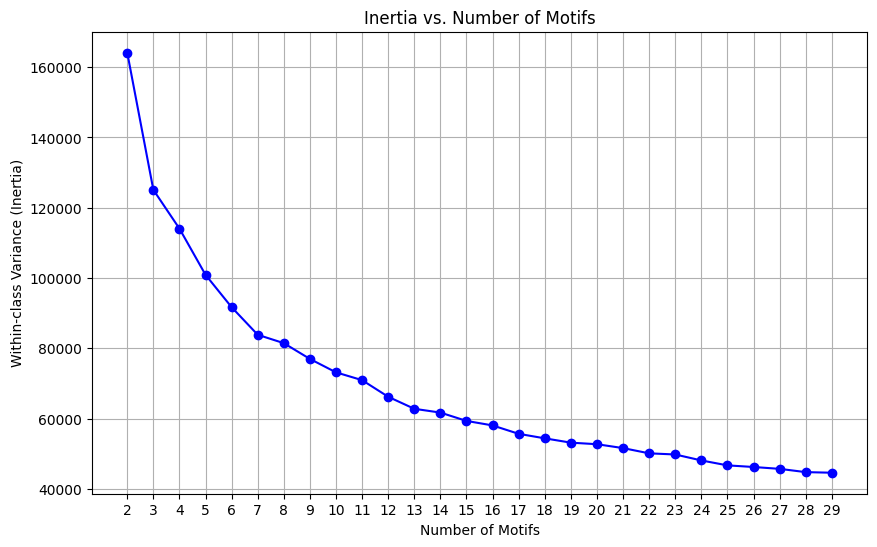

In [10]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Define the range of n_neighborhoods to test
n_neighborhoods_range = range(2, 30)  # Testing from 2 to 10 clusters
inertias = []

# Loop through different n_neighborhoods
for n in tqdm(n_neighborhoods_range):
    km = MiniBatchKMeans(n_clusters=n, random_state=12345)
    km.fit(cell_count.iloc[:,[0,1,2,3,4,5,6,7]].values)
    inertias.append(km.inertia_)

# Plot the inertias (within-class variances)
plt.figure(figsize=(10, 6))
plt.plot(n_neighborhoods_range, inertias, 'bo-')
plt.xlabel('Number of Motifs')
plt.ylabel('Within-class Variance (Inertia)')
plt.title('Inertia vs. Number of Motifs')
plt.xticks(n_neighborhoods_range)
plt.grid(True)
plt.savefig('../output/hop_analysis_121024/1_hop_elbow_seed12345_ROI.pdf')

Suggested optimal number of clusters: 5
Please inspect the elbow plot to confirm or adjust this value.


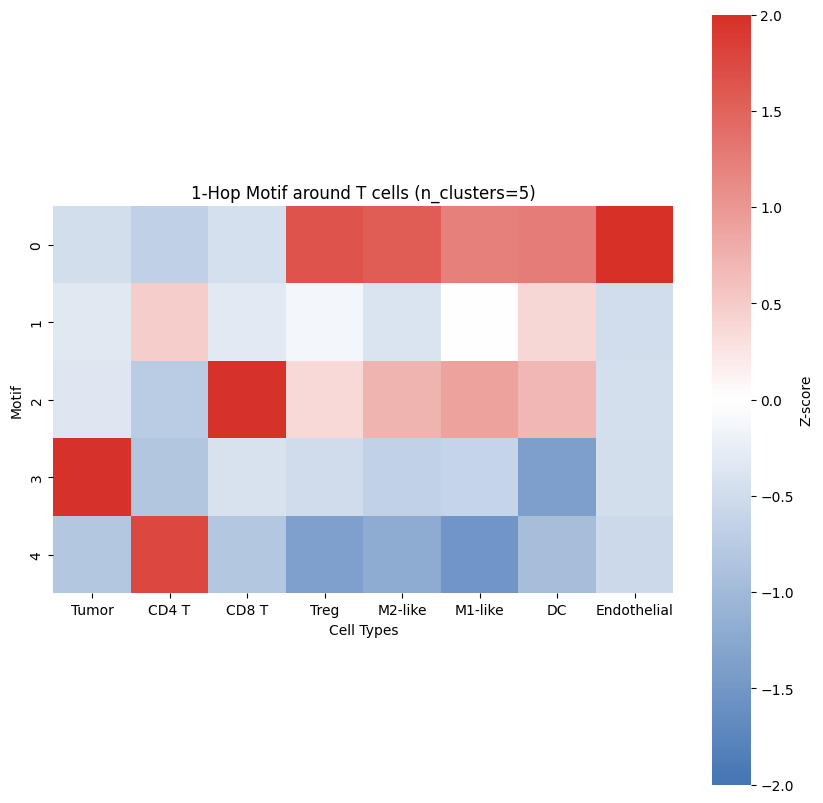

In [12]:
# Define the desired order of cell types
cell_type_order = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']
# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 5
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=12345)

labelskm = km.fit_predict(cell_count.iloc[:,[0,1,2,3,4,5,6,7]].values)
cell_count['Niche'] = labelskm

grouped_df = cell_count.iloc[:,[0,1,2,3,4,5,6,7,8]].groupby('Niche').mean()
z_scores = grouped_df.apply(zscore)

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Z-score'}, vmin=-2, vmax=2, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'1-Hop Motif around T cells (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
plt.savefig('../output/hop_analysis_121024/heatmap/1_hop_motif_z_ROI.pdf')
plt.show()

In [45]:
cell_count

,Tumor,CD4 T,CD8 T,M1-like,Treg,DC,M2-like,Endothelial,Niche
1918,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1
2345,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3
2595,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2
2822,0.0,2.0,3.0,0.0,1.0,1.0,1.0,0.0,2
2834,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...
18214,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,1
18288,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0
18486,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0
18622,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1


In [37]:
df_ls = []

for core in tqdm(annotation['coreName'].unique()):
    print(f'Working on {core}...')
    # Create a new figure for each core
    #fig, ax = plt.subplots(figsize=(20, 20))

    # subset data
    sub_df = annotation.loc[annotation['coreName'] == core] 
    sub_df = sub_df.loc[~sub_df['Annotation'].isin(['Neutrophil', 'Other'])]
    pts = sub_df.loc[:,['X_cent', 'Y_cent']].values
    sub_df_reindex = sub_df.reset_index(drop = True)


    idx = sub_df_reindex[sub_df_reindex['Annotation'] == 'CD4 T'].index

    coreName = sub_df_reindex['coreName'].iloc[idx]
    cellLabel = sub_df_reindex['cellLabel'].iloc[idx]
    Annotation = sub_df_reindex['Annotation'].iloc[idx]

    output_df = pd.concat([coreName, cellLabel, Annotation], axis = 1)

    df_ls.append(output_df)

 38%|███▊      | 11/29 [00:00<00:00, 100.66it/s]

Working on DFCI_4.1...
Working on DFCI_8.1...
Working on DFCI_13.2...
Working on DFCI_15.2...
Working on DFCI_17.1...
Working on DFCI_18.2...
Working on DFCI_19.2...
Working on DFCI_22.2...
Working on DFCI_12.1...
Working on DFCI_14.1...
Working on DFCI_2.2...
Working on DFCI_3.2...
Working on DFCI_7.1...
Working on DFCI_23.2...
Working on Rochester_4...
Working on Rochester_6...
Working on Rochester_11...
Working on Rochester_12...
Working on Rochester_14...
Working on Rochester_18...
Working on Rochester_19...


100%|██████████| 29/29 [00:00<00:00, 99.34it/s] 

Working on Rochester_21...
Working on Rochester_23...
Working on Rochester_13...
Working on Rochester_15...
Working on Rochester_17...
Working on Rochester_7...
Working on Rochester_16...
Working on Rochester_9...


In [46]:
cellLabel_coreName_df = pd.concat(df_ls)

cellLabel_coreName_niche_df = pd.concat([cellLabel_coreName_df.reset_index(drop=True), cell_count.reset_index(drop=True)], axis = 1)

In [47]:
cellLabel_coreName_niche_df

,coreName,cellLabel,Annotation,Tumor,CD4 T,CD8 T,M1-like,Treg,DC,M2-like,Endothelial,Niche
0,DFCI_4.1,1918,CD4 T,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1
1,DFCI_4.1,2345,CD4 T,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3
2,DFCI_4.1,2595,CD4 T,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2
3,DFCI_4.1,2822,CD4 T,0.0,2.0,3.0,0.0,1.0,1.0,1.0,0.0,2
4,DFCI_4.1,2834,CD4 T,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
31399,Rochester_9,18214,CD4 T,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,1
31400,Rochester_9,18288,CD4 T,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0
31401,Rochester_9,18486,CD4 T,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0
31402,Rochester_9,18622,CD4 T,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1


In [48]:
cellLabel_coreName_niche_df.to_csv('../output/hop_analysis_121024/cellLabel_coreName_niche_one_hop_count.csv', index=False)

In [13]:
cell_count.groupby('Niche').mean()

,Tumor,CD4 T,CD8 T,M1-like,Treg,M2-like,DC,Endothelial
Niche,,,,,,,,
0,0.478794,1.215355,1.333487,0.290878,0.455841,0.606490,0.676868,0.455511
1,4.667073,0.467293,0.524774,0.091164,0.073102,0.136441,0.126556,0.065658
2,0.503023,0.813543,3.810060,0.097703,0.176155,0.353470,0.189166,0.130689
3,2.527087,1.046777,1.071222,0.170905,0.212821,0.314759,0.304896,0.176259
4,0.527292,4.119983,0.645388,0.089562,0.099273,0.274807,0.150497,0.111837


In [57]:
tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'].isin(['CD4 T', 'CD8 T'])].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'].isin(['CD4 T', 'CD8 T'])].iterrows()]})

tumor_coreName_ebv

,coreName,ebv_status
0,DFCI_4.1,Positive
1,DFCI_4.1,Positive
2,DFCI_4.1,Positive
3,DFCI_4.1,Positive
4,DFCI_4.1,Positive
...,...,...
79948,Rochester_9,Positive
79949,Rochester_9,Positive
79950,Rochester_9,Positive
79951,Rochester_9,Positive


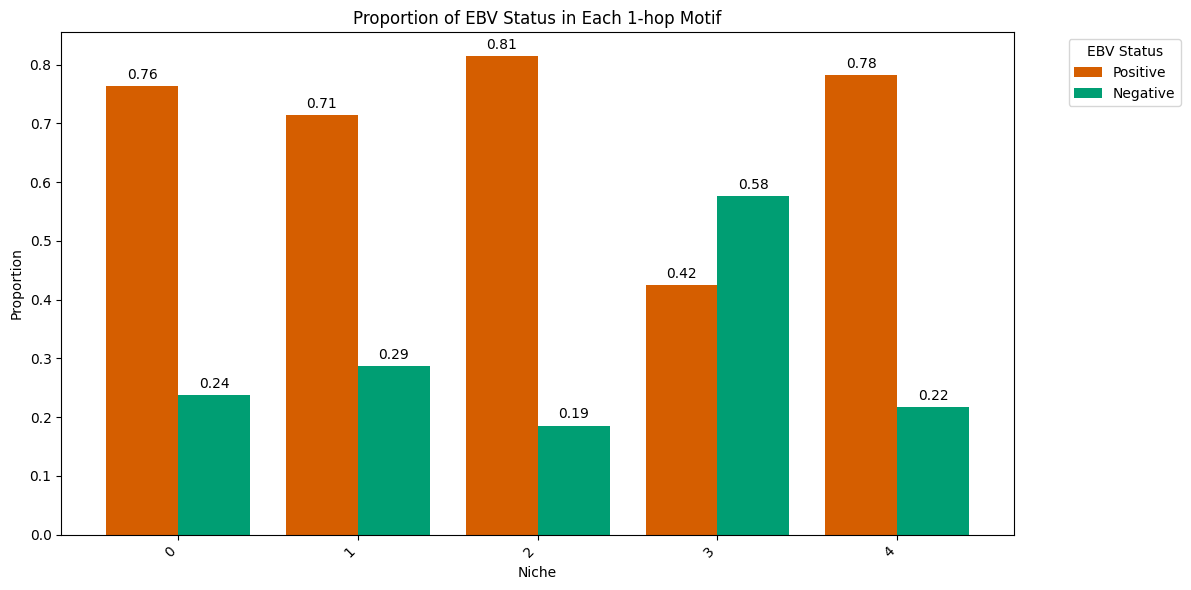

/opt/miniconda3/envs/cellSeg/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


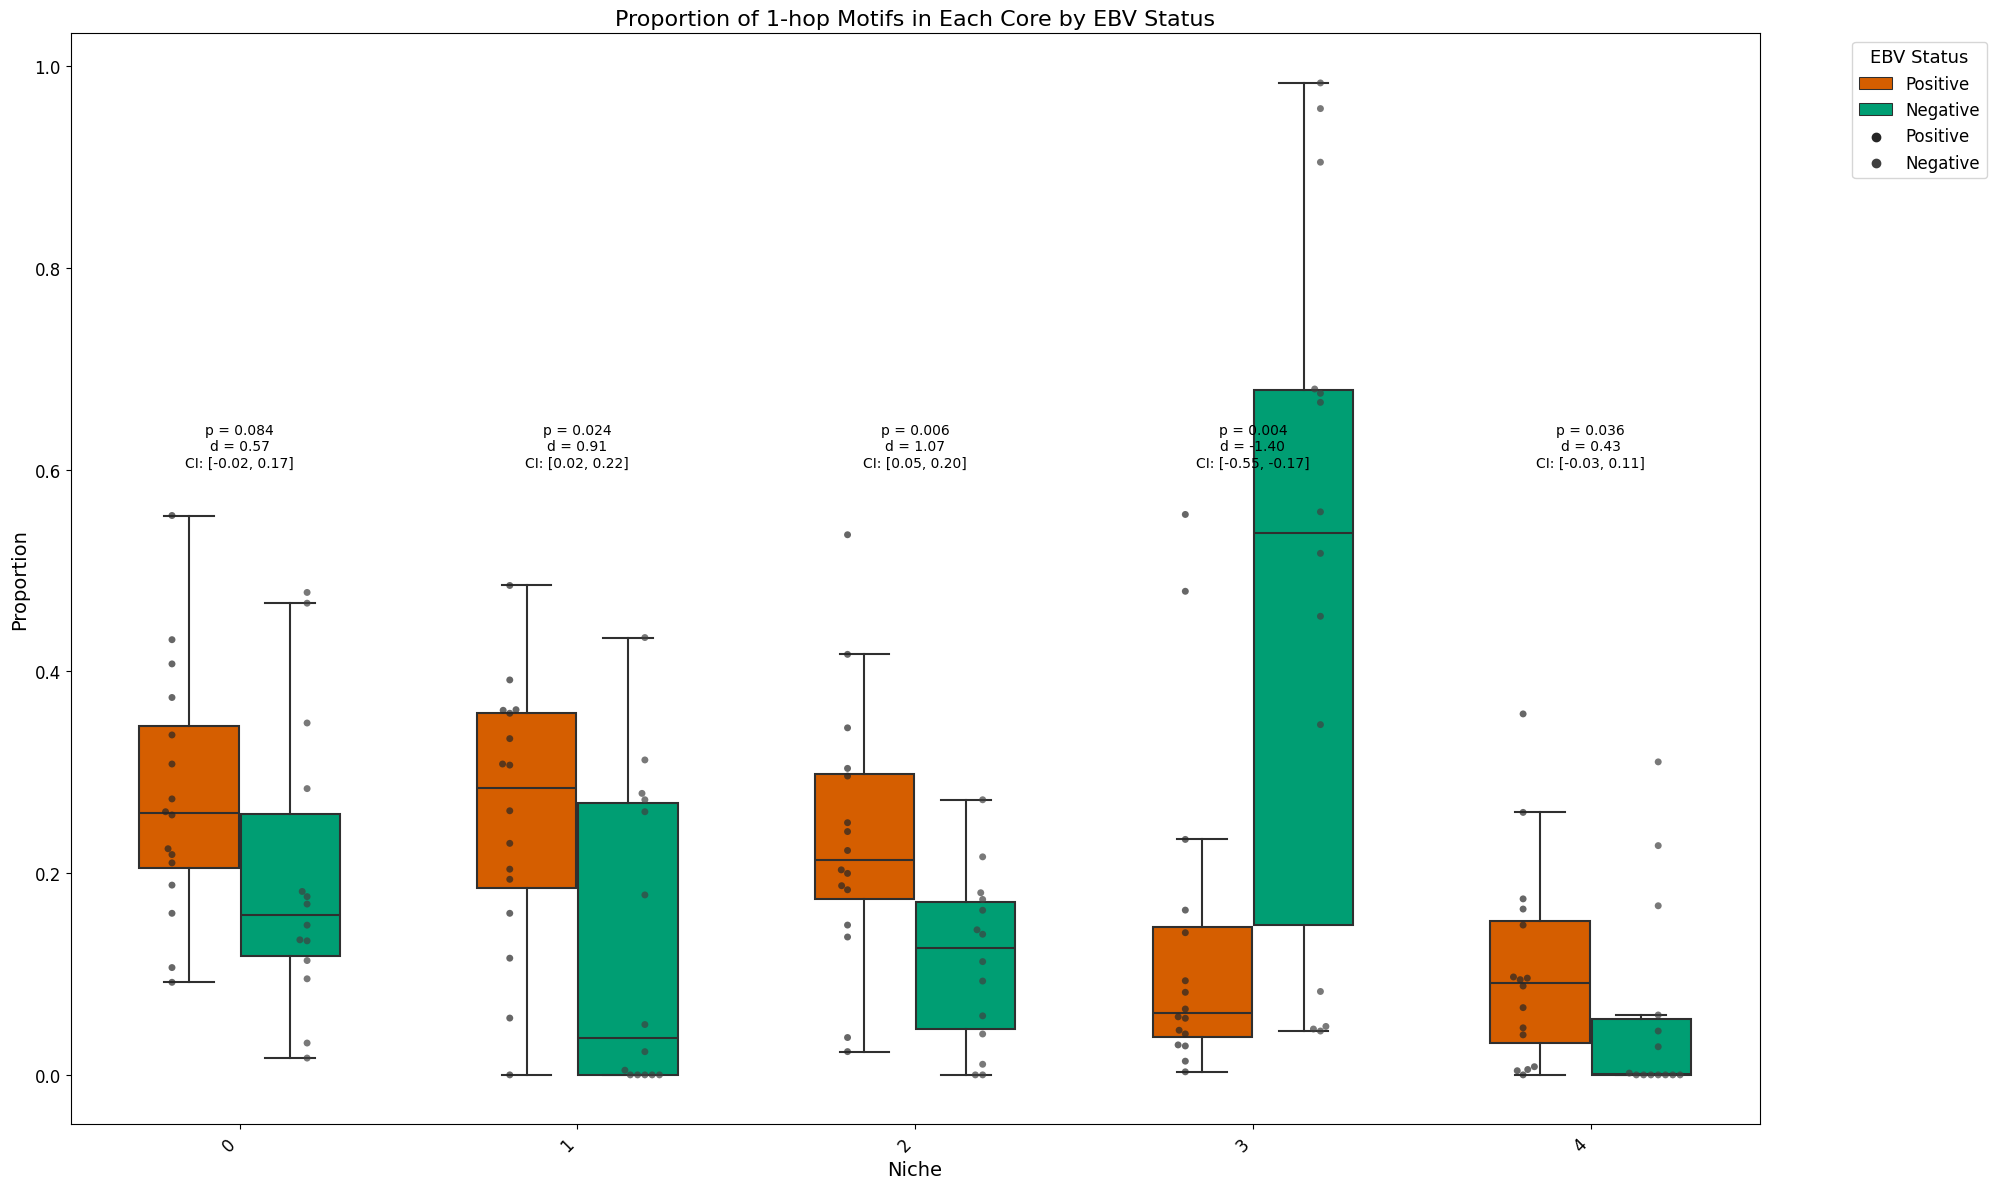

In [61]:
tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'].isin(['CD4 T'])].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'].isin(['CD4 T'])].iterrows()]})

test = pd.concat([cell_count.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

test
# Calculate proportions
props = test.groupby(['Niche', 'ebv_status']).size().unstack(fill_value=0)
props = props.div(props.sum(axis=1), axis=0)

# Reorder columns to have 'Positive' first
props = props[['Positive', 'Negative']]

color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Create the dodged bar plot with custom colors
ax = props.plot(kind='bar', figsize=(12, 6), width=0.8, color=[color_palette['Positive'], color_palette['Negative']])

# Customize the plot
plt.title('Proportion of EBV Status in Each 1-hop Motif')
plt.xlabel('Niche')
plt.ylabel('Proportion')
plt.legend(title='EBV Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.savefig('../output/hop_analysis_112524/plots/1_hop_compose_ROI.pdf')

plt.show()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from scipy.stats import bootstrap

# Calculate proportions
test['count'] = 1
proportions = test.groupby(['coreName', 'ebv_status', 'Niche'])['count'].sum().unstack(level='Niche').fillna(0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)

# Melt the dataframe
proportions_melted = proportions.reset_index().melt(id_vars=['coreName', 'ebv_status'], 
                                                    var_name='Niche', value_name='Proportion')

proportions_melted = proportions_melted.dropna()

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"
    
color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

plt.figure(figsize=(20, 12))

ax = sns.boxplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
                 width=0.6, palette=color_palette, saturation=1.0, showfliers = False)

sns.swarmplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7)


niches = proportions_melted['Niche'].unique()
for i, niche in enumerate(niches):
    niche_data = proportions_melted[proportions_melted['Niche'] == niche]
    ebv_pos = niche_data[niche_data['ebv_status'] == 'Positive']['Proportion']
    ebv_neg = niche_data[niche_data['ebv_status'] == 'Negative']['Proportion']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, 0.6, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Proportion of 1-hop Motifs in Each Core by EBV Status', fontsize=16)
plt.xlabel('Niche', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='EBV Status', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.savefig('../output/hop_analysis_112524/plots/1_hop_in_core_by_ebv_test_ROI.pdf')
plt.show()

/opt/miniconda3/envs/cellSeg/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


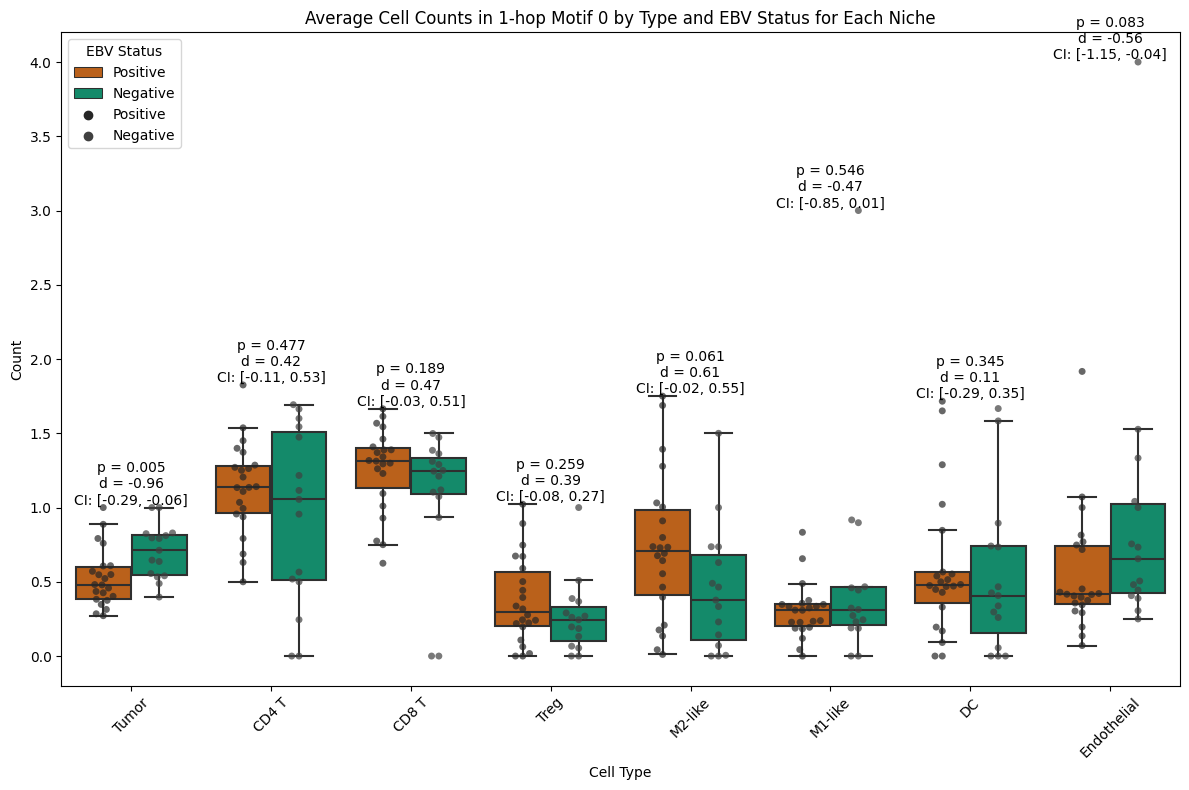

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"

# Assuming 'df' is your DataFrame
cell_types = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']

# Melting the DataFrame
melted_df = test[test['Niche'].isin([0])].iloc[:,0:11].melt(id_vars=['Niche', 'ebv_status', 'coreName'], value_vars=cell_types,
                    var_name='Cell_Type', value_name='Count')

grouped_df = melted_df.groupby(['coreName', 'Niche', 'ebv_status', 'Cell_Type']).mean().reset_index()




color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Creating the plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', palette=color_palette, showfliers = False, order = cell_types)
sns.swarmplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7, order= cell_types)


for i, cell_type in enumerate(cell_types):
    cell_type_data = grouped_df[grouped_df['Cell_Type'] == cell_type]
    ebv_pos = cell_type_data[cell_type_data['ebv_status'] == 'Positive']['Count']
    ebv_neg = cell_type_data[cell_type_data['ebv_status'] == 'Negative']['Count']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, y_max, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Average Cell Counts in 1-hop Motif 0 by Type and EBV Status for Each Niche')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='EBV Status')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.savefig('../output/figures_8bit/motif_stuff/1_hop_motif_0_cell_prop_test.pdf')
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"

# Assuming 'df' is your DataFrame
cell_types = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']

# Melting the DataFrame
melted_df = test[test['Niche'].isin([4])].iloc[:,0:11].melt(id_vars=['Niche', 'ebv_status', 'coreName'], value_vars=cell_types,
                    var_name='Cell_Type', value_name='Count')

grouped_df = melted_df.groupby(['coreName', 'Niche', 'ebv_status', 'Cell_Type']).mean().reset_index()




color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Creating the plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', palette=color_palette, showfliers = False, order = cell_types)
sns.swarmplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7, order= cell_types)


for i, cell_type in enumerate(cell_types):
    cell_type_data = grouped_df[grouped_df['Cell_Type'] == cell_type]
    ebv_pos = cell_type_data[cell_type_data['ebv_status'] == 'Positive']['Count']
    ebv_neg = cell_type_data[cell_type_data['ebv_status'] == 'Negative']['Count']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, y_max, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Average Cell Counts in 1-hop Motif 4 by Type and EBV Status for Each Niche')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='EBV Status')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [ ]:
def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"

# Assuming 'df' is your DataFrame
cell_types = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']

# Melting the DataFrame
melted_df = test[test['Niche'].isin([3,4])].iloc[:,0:11].melt(id_vars=['Niche', 'ebv_status', 'coreName'], value_vars=cell_types,
                    var_name='Cell_Type', value_name='Count')

grouped_df = melted_df.groupby(['coreName', 'Niche', 'ebv_status', 'Cell_Type']).mean().reset_index()




color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Creating the plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', palette=color_palette, showfliers = False, order = cell_types)
sns.swarmplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7, order= cell_types)


for i, cell_type in enumerate(cell_types):
    cell_type_data = grouped_df[grouped_df['Cell_Type'] == cell_type]
    ebv_pos = cell_type_data[cell_type_data['ebv_status'] == 'Positive']['Count']
    ebv_neg = cell_type_data[cell_type_data['ebv_status'] == 'Negative']['Count']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, y_max, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Average Cell Counts in 1-hop Motif 3 + 4 by Type and EBV Status for Each Niche')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='EBV Status')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"

# Assuming 'df' is your DataFrame
cell_types = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']

# Melting the DataFrame
melted_df = test[test['Niche'].isin([3,4])].iloc[:,0:11].melt(id_vars=['Niche', 'ebv_status', 'coreName'], value_vars=cell_types,
                    var_name='Cell_Type', value_name='Count')

grouped_df = melted_df.groupby(['coreName', 'Niche', 'ebv_status', 'Cell_Type']).mean().reset_index()




color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Creating the plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', palette=color_palette, showfliers = False, order = cell_types)
sns.swarmplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7)


for i, cell_type in enumerate(cell_types):
    cell_type_data = grouped_df[grouped_df['Cell_Type'] == cell_type]
    ebv_pos = cell_type_data[cell_type_data['ebv_status'] == 'Positive']['Count']
    ebv_neg = cell_type_data[cell_type_data['ebv_status'] == 'Negative']['Count']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, 3.5, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Average Cell Counts in 1-hop Motif 3 by Type and EBV Status for Each Niche')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='EBV Status')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [ ]:
# Define the desired order of cell types
cell_type_order = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']
# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 5
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=123456)

labelskm = km.fit_predict(cell_count.iloc[:,[0,1,2,3,4,5,6,7]].values)
cell_count['Niche'] = labelskm

grouped_df = cell_count.iloc[:,[0,1,2,3,4,5,6,7,8]].groupby('Niche').mean()
z_scores = grouped_df

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Mean Count'}, vmin=-max_abs_val, vmax=max_abs_val, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'1-Hop Motif around Tumor (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
#plt.savefig('../output/figures_8bit/1_hop_motif.pdf')
plt.show()

In [ ]:
cell_count_scaled.iloc[:,[0,1,2,3,4,5,6,7]]

In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Define the range of n_neighborhoods to test
n_neighborhoods_range = range(2, 30)  # Testing from 2 to 10 clusters
inertias = []

# Loop through different n_neighborhoods
for n in tqdm(n_neighborhoods_range):
    km = MiniBatchKMeans(n_clusters=n, random_state=12345)
    km.fit(cell_count_scaled.iloc[:,[0,1,2,3,4,5,6,7]].values)
    inertias.append(km.inertia_)

# Plot the inertias (within-class variances)
plt.figure(figsize=(10, 6))
plt.plot(n_neighborhoods_range, inertias, 'bo-')
plt.xlabel('Number of Motifs')
plt.ylabel('Within-class Variance (Inertia)')
plt.title('Inertia vs. Number of Motifs')
plt.xticks(n_neighborhoods_range)
plt.grid(True)

In [ ]:
# Define the desired order of cell types
cell_type_order = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']
# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 8
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=12345)

labelskm = km.fit_predict(cell_count_scaled.iloc[:,[0,1,2,3,4,5,6,7]].values)
cell_count_scaled['Niche'] = labelskm
cell_count['Niche'] = labelskm

grouped_df = cell_count_scaled.iloc[:,[0,1,2,3,4,5,6,7,8]].groupby('Niche').mean()
z_scores = grouped_df

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Z-score'}, vmin=-2, vmax=2, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'1-Hop Motif around Tumor (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
#plt.savefig('../output/figures_8bit/1_hop_motif.pdf')
plt.show()

In [ ]:
tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()]})

test = pd.concat([cell_count_scaled.reset_index(drop=True), tumor_coreName_ebv], axis = 1)


# Calculate proportions
props = test.groupby(['Niche', 'ebv_status']).size().unstack(fill_value=0)
props = props.div(props.sum(axis=1), axis=0)

# Reorder columns to have 'Positive' first
props = props[['Positive', 'Negative']]

color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Create the dodged bar plot with custom colors
ax = props.plot(kind='bar', figsize=(12, 6), width=0.8, color=[color_palette['Positive'], color_palette['Negative']])

# Customize the plot
plt.title('Proportion of EBV Status in Each 1-hop Motif')
plt.xlabel('Niche')
plt.ylabel('Proportion')
plt.legend(title='EBV Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

#plt.savefig('../output/figures_8bit/motif_composition/1_hop_compose.pdf')

plt.show()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from scipy.stats import bootstrap

# Calculate proportions
test['count'] = 1
proportions = test.groupby(['coreName', 'ebv_status', 'Niche'])['count'].sum().unstack(level='Niche').fillna(0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)

# Melt the dataframe
proportions_melted = proportions.reset_index().melt(id_vars=['coreName', 'ebv_status'], 
                                                    var_name='Niche', value_name='Proportion')

proportions_melted = proportions_melted.dropna()

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"
    
color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

plt.figure(figsize=(20, 12))

ax = sns.boxplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
                 width=0.6, palette=color_palette, saturation=1.0, showfliers = False)

sns.swarmplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7)


niches = proportions_melted['Niche'].unique()
for i, niche in enumerate(niches):
    niche_data = proportions_melted[proportions_melted['Niche'] == niche]
    ebv_pos = niche_data[niche_data['ebv_status'] == 'Positive']['Proportion']
    ebv_neg = niche_data[niche_data['ebv_status'] == 'Negative']['Proportion']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, 0.8, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Proportion of 1-hop Motifs in Each Core by EBV Status (n_neg=16, n_pos=22)', fontsize=16)
plt.xlabel('Niche', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='EBV Status', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
#plt.savefig('../output/figures_8bit/motif_composition/1_hop_test.pdf')
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()]})

test = pd.concat([cell_count.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"

# Assuming 'df' is your DataFrame
cell_types = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']

# Melting the DataFrame
melted_df = test[test['Niche'].isin([4])].iloc[:,0:11].melt(id_vars=['Niche', 'ebv_status', 'coreName'], value_vars=cell_types,
                    var_name='Cell_Type', value_name='Count')

grouped_df = melted_df.groupby(['coreName', 'Niche', 'ebv_status', 'Cell_Type']).mean().reset_index()




color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Creating the plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', palette=color_palette, showfliers = False, order = cell_types)
sns.swarmplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7, order= cell_types)


for i, cell_type in enumerate(cell_types):
    cell_type_data = grouped_df[grouped_df['Cell_Type'] == cell_type]
    ebv_pos = cell_type_data[cell_type_data['ebv_status'] == 'Positive']['Count']
    ebv_neg = cell_type_data[cell_type_data['ebv_status'] == 'Negative']['Count']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, y_max, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Average Cell Counts in 1-hop Motif 4 by Type and EBV Status for Each Niche')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='EBV Status')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


In [ ]:
tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()]})

test = pd.concat([cell_count.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"

# Assuming 'df' is your DataFrame
cell_types = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']

# Melting the DataFrame
melted_df = test[test['Niche'].isin([5])].iloc[:,0:11].melt(id_vars=['Niche', 'ebv_status', 'coreName'], value_vars=cell_types,
                    var_name='Cell_Type', value_name='Count')

grouped_df = melted_df.groupby(['coreName', 'Niche', 'ebv_status', 'Cell_Type']).mean().reset_index()




color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Creating the plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', palette=color_palette, showfliers = False, order = cell_types)
sns.swarmplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7, order= cell_types)


for i, cell_type in enumerate(cell_types):
    cell_type_data = grouped_df[grouped_df['Cell_Type'] == cell_type]
    ebv_pos = cell_type_data[cell_type_data['ebv_status'] == 'Positive']['Count']
    ebv_neg = cell_type_data[cell_type_data['ebv_status'] == 'Negative']['Count']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, y_max, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Average Cell Counts in 1-hop Motif 5 by Type and EBV Status for Each Niche')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='EBV Status')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [ ]:
tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()]})

test = pd.concat([cell_count.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"

# Assuming 'df' is your DataFrame
cell_types = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']

# Melting the DataFrame
melted_df = test[test['Niche'].isin([4,5])].iloc[:,0:11].melt(id_vars=['Niche', 'ebv_status', 'coreName'], value_vars=cell_types,
                    var_name='Cell_Type', value_name='Count')

grouped_df = melted_df.groupby(['coreName', 'Niche', 'ebv_status', 'Cell_Type']).mean().reset_index()




color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Creating the plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', palette=color_palette, showfliers = False, order = cell_types)
sns.swarmplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7, order= cell_types)


for i, cell_type in enumerate(cell_types):
    cell_type_data = grouped_df[grouped_df['Cell_Type'] == cell_type]
    ebv_pos = cell_type_data[cell_type_data['ebv_status'] == 'Positive']['Count']
    ebv_neg = cell_type_data[cell_type_data['ebv_status'] == 'Negative']['Count']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, y_max, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Average Cell Counts in 1-hop Motif 4+5 by Type and EBV Status for Each Niche')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='EBV Status')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [ ]:
# Define the desired order of cell types
cell_type_order = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']
# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 8
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=123456)

labelskm = km.fit_predict(cell_count_scaled.iloc[:,[0,1,2,3,4,5,6,7]].values)
cell_count['Niche'] = labelskm

grouped_df = cell_count.iloc[:,[0,1,2,3,4,5,6,7,8]].groupby('Niche').mean()
z_scores = grouped_df

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Mean Count'}, vmin=-max_abs_val, vmax=max_abs_val, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'1-Hop Motif around Tumor (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
#plt.savefig('../output/figures_8bit/1_hop_motif.pdf')
plt.show()

### 1+2-hop

100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


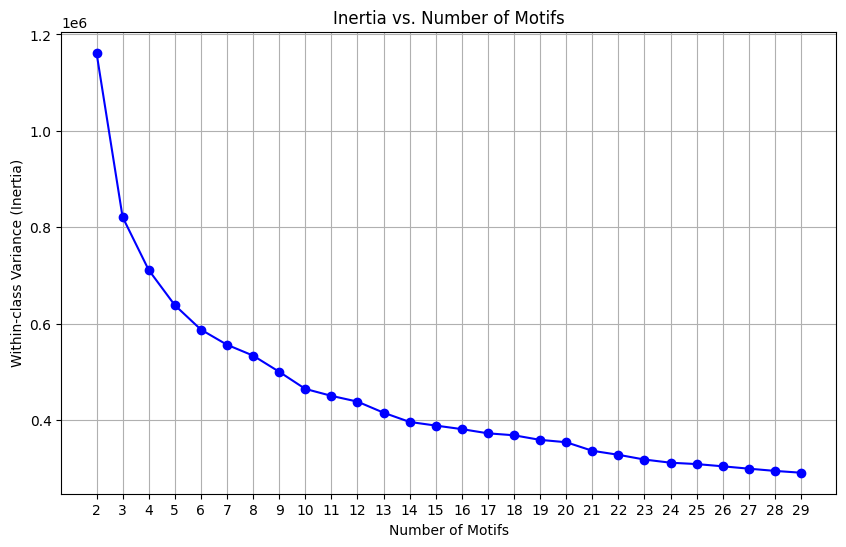

In [62]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Define the range of n_neighborhoods to test
n_neighborhoods_range = range(2, 30)  # Testing from 2 to 10 clusters
inertias = []

# Loop through different n_neighborhoods
for n in tqdm(n_neighborhoods_range):
    km = MiniBatchKMeans(n_clusters=n, random_state=12345)
    km.fit(cell_count_one_and_two.iloc[:,[0,1,2,3,4,5,6,7]].values)
    inertias.append(km.inertia_)

# Plot the inertias (within-class variances)
plt.figure(figsize=(10, 6))
plt.plot(n_neighborhoods_range, inertias, 'bo-')
plt.xlabel('Number of Motifs')
plt.ylabel('Within-class Variance (Inertia)')
plt.title('Inertia vs. Number of Motifs')
plt.xticks(n_neighborhoods_range)
plt.grid(True)
plt.savefig('../output/hop_analysis_112524/plots/1+2_hop_elbow_seed12345_ROI.pdf')

Suggested optimal number of clusters: 5
Please inspect the elbow plot to confirm or adjust this value.


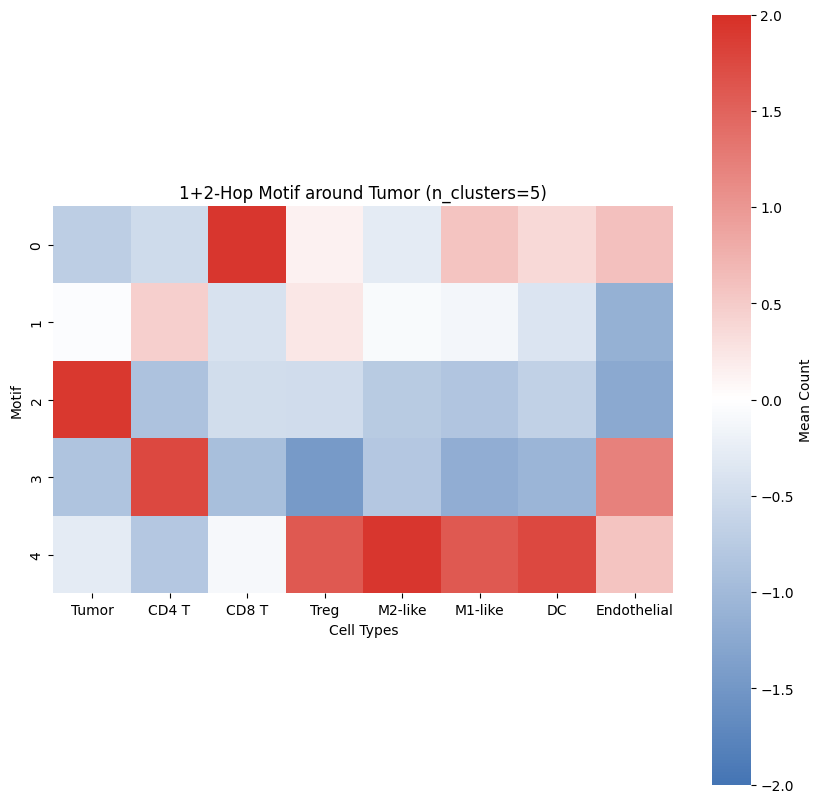

In [63]:
# Define the desired order of cell types
cell_type_order = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']
# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 5
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=12345)

labelskm = km.fit_predict(cell_count_one_and_two.iloc[:,[0,1,2,3,4,5,6,7]].values)
cell_count_one_and_two['Niche'] = labelskm

grouped_df = cell_count_one_and_two.iloc[:,[0,1,2,3,4,5,6,7,8]].groupby('Niche').mean()
z_scores = grouped_df.apply(zscore)

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Mean Count'}, vmin=-2, vmax=2, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'1+2-Hop Motif around Tumor (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
plt.savefig('../output/hop_analysis_112524/heatmap/1+2_hop_motif_z_ROI.pdf')
plt.show()

In [16]:
cell_count_one_and_two.groupby('Niche').mean()

,Tumor,CD4 T,CD8 T,M1-like,Endothelial,DC,Treg,M2-like
Niche,,,,,,,,
0,3.811090,3.026126,4.620208,0.704346,1.238656,1.949134,1.150147,1.313676
1,1.630687,2.711559,10.704506,0.356846,0.578685,0.692203,0.691054,1.478346
2,11.479724,2.377534,2.342322,0.437213,0.401730,0.631860,0.371790,0.688362
3,2.705321,8.643597,3.731724,0.496719,0.718599,0.775146,0.519789,0.873680
4,1.173211,14.728044,1.131854,0.149861,0.319586,0.304368,0.123257,1.265451


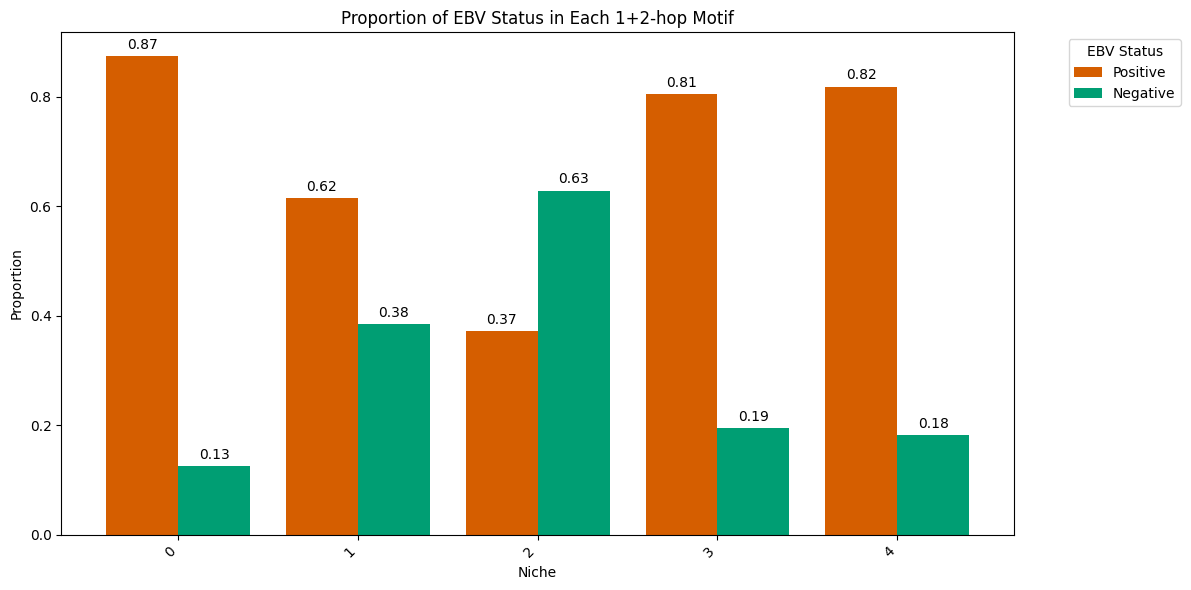

/opt/miniconda3/envs/cellSeg/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


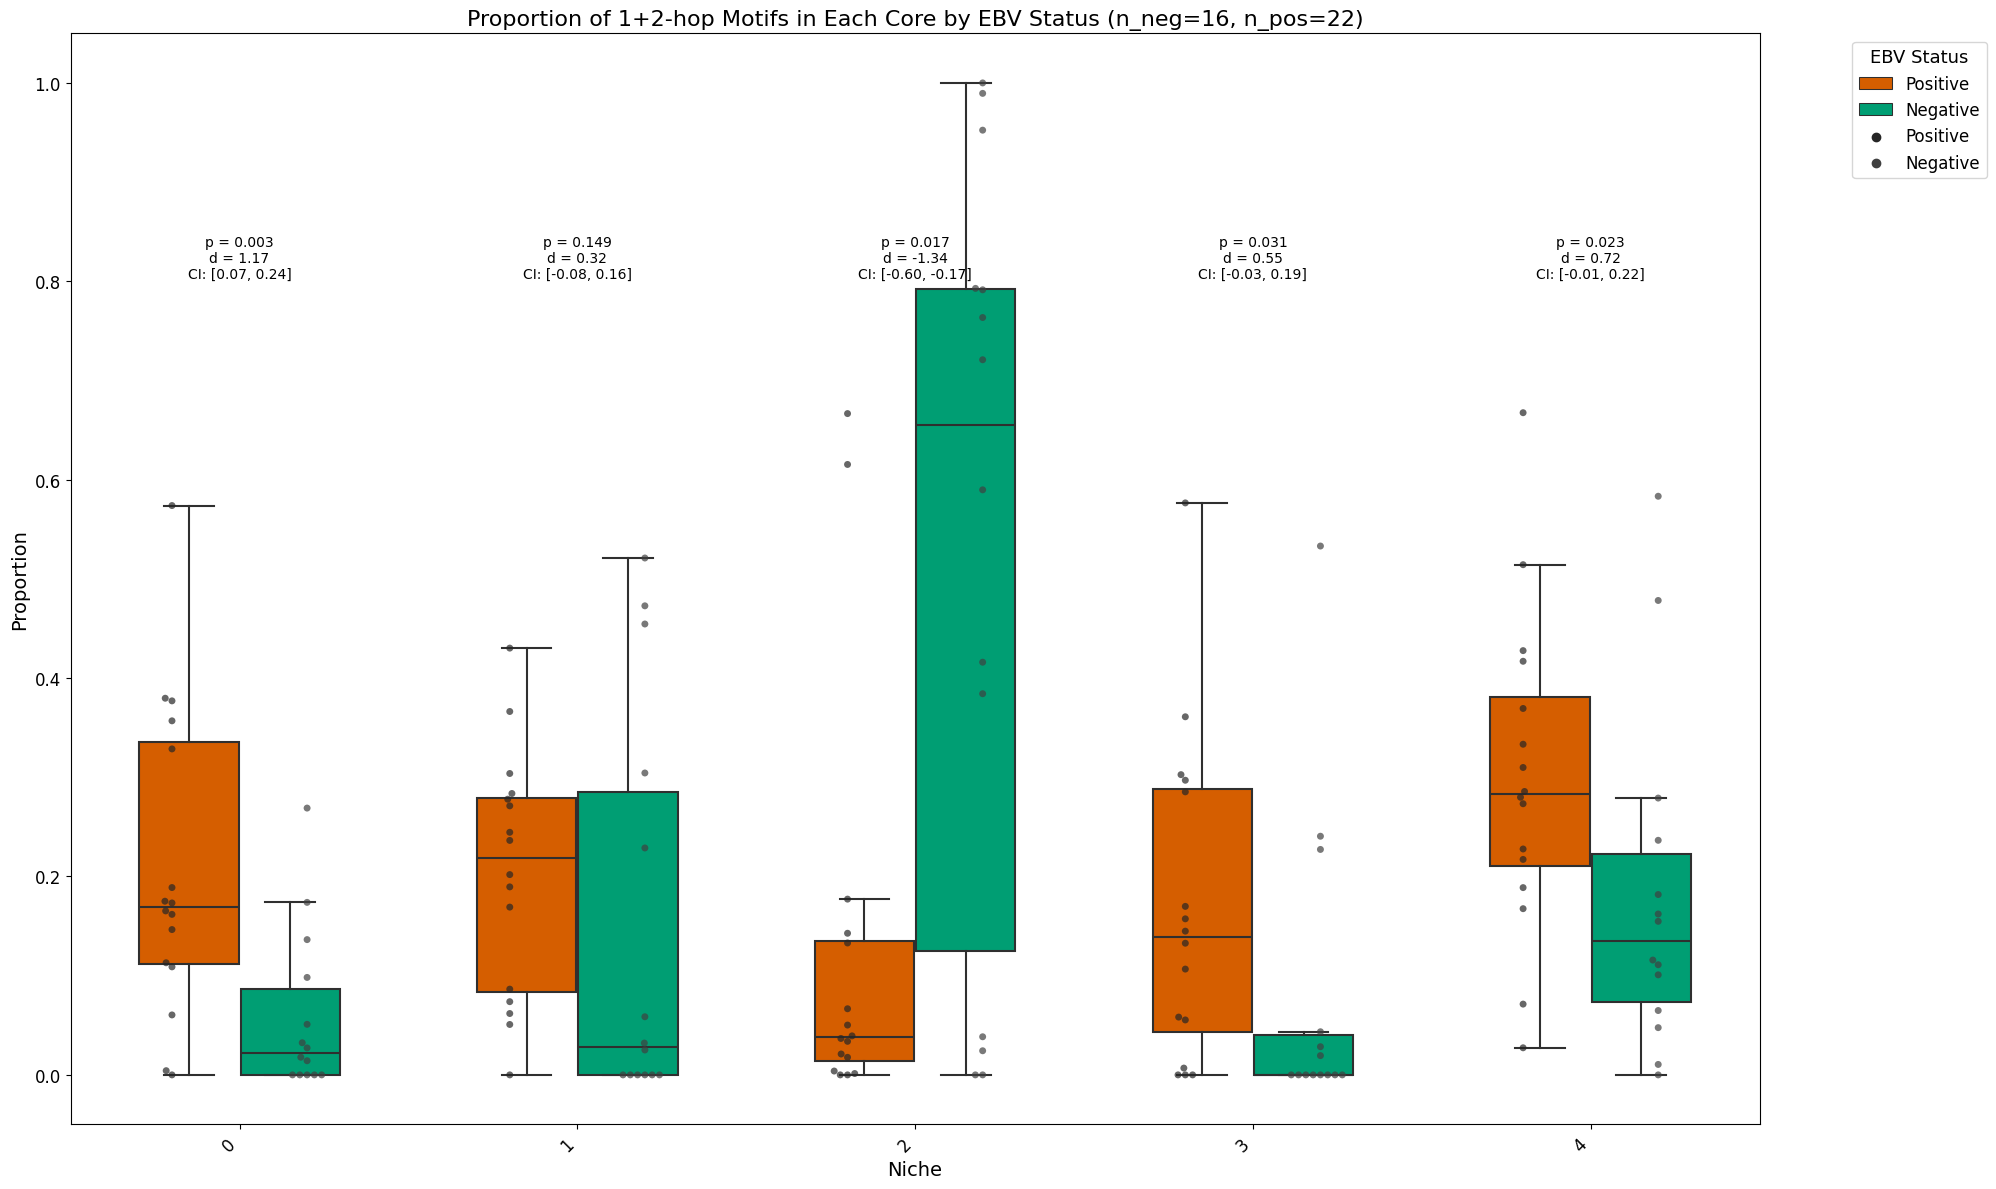

In [64]:
tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'].isin(['CD4 T'])].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'].isin(['CD4 T'])].iterrows()]})

test = pd.concat([cell_count_one_and_two.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

test
# Calculate proportions
props = test.groupby(['Niche', 'ebv_status']).size().unstack(fill_value=0)
props = props.div(props.sum(axis=1), axis=0)

# Reorder columns to have 'Positive' first
props = props[['Positive', 'Negative']]

color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Create the dodged bar plot with custom colors
ax = props.plot(kind='bar', figsize=(12, 6), width=0.8, color=[color_palette['Positive'], color_palette['Negative']])

# Customize the plot
plt.title('Proportion of EBV Status in Each 1+2-hop Motif')
plt.xlabel('Niche')
plt.ylabel('Proportion')
plt.legend(title='EBV Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.savefig('../output/hop_analysis_112524/plots/1+2_hop_compose_ROI.pdf')

plt.show()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from scipy.stats import bootstrap

# Calculate proportions
test['count'] = 1
proportions = test.groupby(['coreName', 'ebv_status', 'Niche'])['count'].sum().unstack(level='Niche').fillna(0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)

# Melt the dataframe
proportions_melted = proportions.reset_index().melt(id_vars=['coreName', 'ebv_status'], 
                                                    var_name='Niche', value_name='Proportion')

proportions_melted = proportions_melted.dropna()

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"
    
color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

plt.figure(figsize=(20, 12))

ax = sns.boxplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
                 width=0.6, palette=color_palette, saturation=1.0, showfliers = False)

sns.swarmplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7)


niches = proportions_melted['Niche'].unique()
for i, niche in enumerate(niches):
    niche_data = proportions_melted[proportions_melted['Niche'] == niche]
    ebv_pos = niche_data[niche_data['ebv_status'] == 'Positive']['Proportion']
    ebv_neg = niche_data[niche_data['ebv_status'] == 'Negative']['Proportion']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, 0.8, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Proportion of 1+2-hop Motifs in Each Core by EBV Status (n_neg=16, n_pos=22)', fontsize=16)
plt.xlabel('Niche', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='EBV Status', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.savefig('../output/hop_analysis_112524/plots/1+2_hop_in_core_by_ebv_test_ROI.pdf')
plt.show()

/opt/miniconda3/envs/cellSeg/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


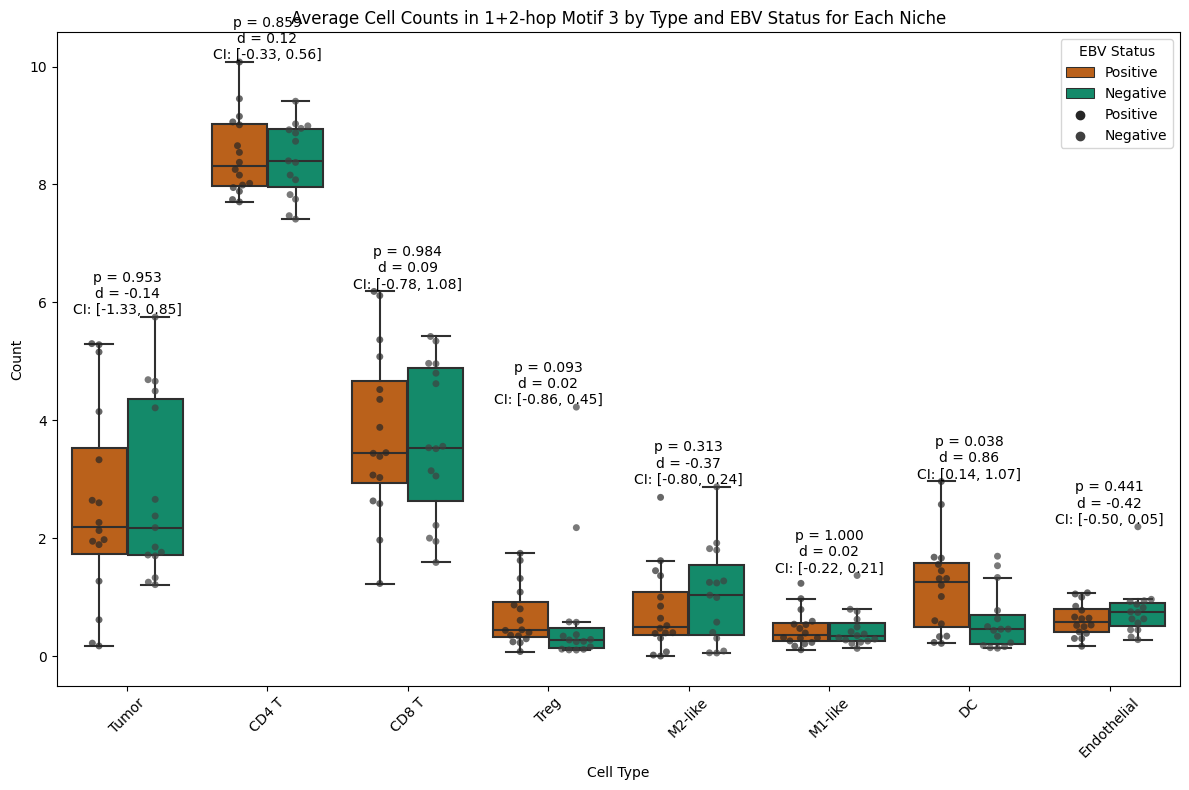

<Figure size 640x480 with 0 Axes>

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()]})

test = pd.concat([cell_count_one_and_two.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"

# Assuming 'df' is your DataFrame
cell_types = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']

# Melting the DataFrame
melted_df = test[test['Niche'].isin([3])].iloc[:,0:11].melt(id_vars=['Niche', 'ebv_status', 'coreName'], value_vars=cell_types,
                    var_name='Cell_Type', value_name='Count')

grouped_df = melted_df.groupby(['coreName', 'Niche', 'ebv_status', 'Cell_Type']).mean().reset_index()




color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Creating the plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', palette=color_palette, showfliers = False, order = cell_types)
sns.swarmplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7, order= cell_types)


for i, cell_type in enumerate(cell_types):
    cell_type_data = grouped_df[grouped_df['Cell_Type'] == cell_type]
    ebv_pos = cell_type_data[cell_type_data['ebv_status'] == 'Positive']['Count']
    ebv_neg = cell_type_data[cell_type_data['ebv_status'] == 'Negative']['Count']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, y_max, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Average Cell Counts in 1+2-hop Motif 3 by Type and EBV Status for Each Niche')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='EBV Status')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()
plt.savefig('../output/figures_8bit/motif_stuff/1+2_hop_motif_3_cell_prop_test.pdf')

In [ ]:
# Define the desired order of cell types
cell_type_order = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']
# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 5
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=123456)

labelskm = km.fit_predict(cell_count_one_and_two.iloc[:,[0,1,2,3,4,5,6,7]].values)
cell_count_one_and_two['Niche'] = labelskm

grouped_df = cell_count_one_and_two.iloc[:,[0,1,2,3,4,5,6,7,8]].groupby('Niche').mean()
z_scores = grouped_df

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Mean Count'}, vmin=-max_abs_val, vmax=max_abs_val, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'1+2-Hop Motif around Tumor (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
#plt.savefig('../output/figures_8bit/1_hop_motif.pdf')
plt.show()

In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Define the range of n_neighborhoods to test
n_neighborhoods_range = range(2, 30)  # Testing from 2 to 10 clusters
inertias = []

# Loop through different n_neighborhoods
for n in tqdm(n_neighborhoods_range):
    km = MiniBatchKMeans(n_clusters=n, random_state=123456)
    km.fit(cell_count_one_and_two_scaled.iloc[:,[0,1,2,3,4,5,6,7]].values)
    inertias.append(km.inertia_)

# Plot the inertias (within-class variances)
plt.figure(figsize=(10, 6))
plt.plot(n_neighborhoods_range, inertias, 'bo-')
plt.xlabel('Number of Motifs')
plt.ylabel('Within-class Variance (Inertia)')
plt.title('Inertia vs. Number of Motifs')
plt.xticks(n_neighborhoods_range)
plt.grid(True)

In [ ]:
# Define the desired order of cell types
cell_type_order = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']
# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 8
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=123456)

labelskm = km.fit_predict(cell_count_one_and_two_scaled.iloc[:,[0,1,2,3,4,5,6,7]].values)
cell_count_one_and_two_scaled['Niche'] = labelskm
cell_count_one_and_two['Niche'] = labelskm

grouped_df = cell_count_one_and_two_scaled.iloc[:,[0,1,2,3,4,5,6,7,8]].groupby('Niche').mean()
z_scores = grouped_df

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Z-score'}, vmin=-1, vmax=1, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'1+2-Hop Motif around Tumor (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
#plt.savefig('../output/figures_8bit/1_hop_motif.pdf')
plt.show()

In [ ]:
tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()]})

test = pd.concat([cell_count_one_and_two_scaled.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

test
# Calculate proportions
props = test.groupby(['Niche', 'ebv_status']).size().unstack(fill_value=0)
props = props.div(props.sum(axis=1), axis=0)

# Reorder columns to have 'Positive' first
props = props[['Positive', 'Negative']]

color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Create the dodged bar plot with custom colors
ax = props.plot(kind='bar', figsize=(12, 6), width=0.8, color=[color_palette['Positive'], color_palette['Negative']])

# Customize the plot
plt.title('Proportion of EBV Status in Each 1+2-hop Motif')
plt.xlabel('Niche')
plt.ylabel('Proportion')
plt.legend(title='EBV Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

#plt.savefig('../output/figures_8bit/motif_composition/1_hop_compose.pdf')

plt.show()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from scipy.stats import bootstrap

# Calculate proportions
test['count'] = 1
proportions = test.groupby(['coreName', 'ebv_status', 'Niche'])['count'].sum().unstack(level='Niche').fillna(0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)

# Melt the dataframe
proportions_melted = proportions.reset_index().melt(id_vars=['coreName', 'ebv_status'], 
                                                    var_name='Niche', value_name='Proportion')

proportions_melted = proportions_melted.dropna()

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"
    
color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

plt.figure(figsize=(20, 12))

ax = sns.boxplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
                 width=0.6, palette=color_palette, saturation=1.0, showfliers = False)

sns.swarmplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7)


niches = proportions_melted['Niche'].unique()
for i, niche in enumerate(niches):
    niche_data = proportions_melted[proportions_melted['Niche'] == niche]
    ebv_pos = niche_data[niche_data['ebv_status'] == 'Positive']['Proportion']
    ebv_neg = niche_data[niche_data['ebv_status'] == 'Negative']['Proportion']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, 0.8, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Proportion of 1+2-hop Motifs in Each Core by EBV Status (n_neg=16, n_pos=22)', fontsize=16)
plt.xlabel('Niche', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='EBV Status', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
#plt.savefig('../output/figures_8bit/motif_composition/1_hop_test.pdf')
plt.show()

In [ ]:
test[test['Niche'].isin([6])].iloc[:,0:11].melt(id_vars=['Niche', 'ebv_status', 'coreName'], value_vars=cell_types,
                    var_name='Cell_Type', value_name='Count')

In [ ]:
cell_count_one_and_two['Niche'].unique()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()]})

test = pd.concat([cell_count_one_and_two.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"

# Assuming 'df' is your DataFrame
cell_types = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']

# Melting the DataFrame
melted_df = test[test['Niche'].isin([2,6])].iloc[:,0:11].melt(id_vars=['Niche', 'ebv_status', 'coreName'], value_vars=cell_types,
                    var_name='Cell_Type', value_name='Count')

grouped_df = melted_df.groupby(['coreName', 'Niche', 'ebv_status', 'Cell_Type']).mean().reset_index()




color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Creating the plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', palette=color_palette, showfliers = False, order = cell_types)
sns.swarmplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7, order= cell_types)


for i, cell_type in enumerate(cell_types):
    cell_type_data = grouped_df[grouped_df['Cell_Type'] == cell_type]
    ebv_pos = cell_type_data[cell_type_data['ebv_status'] == 'Positive']['Count']
    ebv_neg = cell_type_data[cell_type_data['ebv_status'] == 'Negative']['Count']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, y_max, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Average Cell Counts in 1+2-hop Motif 2+6 by Type and EBV Status for Each Niche')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='EBV Status')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [ ]:
# Define the desired order of cell types
cell_type_order = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']
# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 8
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=123456)

labelskm = km.fit_predict(cell_count_one_and_two_scaled.iloc[:,[0,1,2,3,4,5,6,7]].values)
cell_count_one_and_two['Niche'] = labelskm

grouped_df = cell_count_one_and_two.iloc[:,[0,1,2,3,4,5,6,7,8]].groupby('Niche').mean()
z_scores = grouped_df

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Mean Count'}, vmin=-max_abs_val, vmax=max_abs_val, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'1+2-Hop Motif around Tumor (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
#plt.savefig('../output/figures_8bit/1_hop_motif.pdf')
plt.show()

## K-means

In [ ]:
cell_count.iloc[:,[0,1,2,3,4,5,6,7]]

In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Define the range of n_neighborhoods to test
n_neighborhoods_range = range(2, 30)  # Testing from 2 to 10 clusters
inertias = []

# Loop through different n_neighborhoods
for n in tqdm(n_neighborhoods_range):
    km = KMeans(n_clusters=n, random_state=123456)
    km.fit(cell_count.iloc[:,[0,1,2,3,4,5,6,7]].values)
    inertias.append(km.inertia_)

# Plot the inertias (within-class variances)
plt.figure(figsize=(10, 6))
plt.plot(n_neighborhoods_range, inertias, 'bo-')
plt.xlabel('Number of Motifs')
plt.ylabel('Within-class Variance (Inertia)')
plt.title('Inertia vs. Number of Motifs')
plt.xticks(n_neighborhoods_range)
plt.grid(True)

In [ ]:
# Define the desired order of cell types
cell_type_order = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']
# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 7
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = KMeans(n_clusters=n_neighborhoods, random_state=123456)

labelskm = km.fit_predict(cell_count.iloc[:,[0,1,2,3,4,5,6,7]].values)
cell_count['Niche'] = labelskm

grouped_df = cell_count.iloc[:,[0,1,2,3,4,5,6,7,8]].groupby('Niche').mean()
z_scores = grouped_df

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Mean Count'}, vmin=-max_abs_val, vmax=max_abs_val, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'1-Hop Motif around Tumor (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
#plt.savefig('../output/figures_8bit/1_hop_motif.pdf')
plt.show()

In [ ]:
tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()]})

test = pd.concat([cell_count.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

test
# Calculate proportions
props = test.groupby(['Niche', 'ebv_status']).size().unstack(fill_value=0)
props = props.div(props.sum(axis=1), axis=0)

# Reorder columns to have 'Positive' first
props = props[['Positive', 'Negative']]

color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Create the dodged bar plot with custom colors
ax = props.plot(kind='bar', figsize=(12, 6), width=0.8, color=[color_palette['Positive'], color_palette['Negative']])

# Customize the plot
plt.title('Proportion of EBV Status in Each 1-hop Motif')
plt.xlabel('Niche')
plt.ylabel('Proportion')
plt.legend(title='EBV Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

#plt.savefig('../output/figures_8bit/motif_composition/1_hop_compose.pdf')

plt.show()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from scipy.stats import bootstrap

# Calculate proportions
test['count'] = 1
proportions = test.groupby(['coreName', 'ebv_status', 'Niche'])['count'].sum().unstack(level='Niche').fillna(0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)

# Melt the dataframe
proportions_melted = proportions.reset_index().melt(id_vars=['coreName', 'ebv_status'], 
                                                    var_name='Niche', value_name='Proportion')

proportions_melted = proportions_melted.dropna()

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"
    
color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

plt.figure(figsize=(20, 12))

ax = sns.boxplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
                 width=0.6, palette=color_palette, saturation=1.0, showfliers = False)

sns.swarmplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7)


niches = proportions_melted['Niche'].unique()
for i, niche in enumerate(niches):
    niche_data = proportions_melted[proportions_melted['Niche'] == niche]
    ebv_pos = niche_data[niche_data['ebv_status'] == 'Positive']['Proportion']
    ebv_neg = niche_data[niche_data['ebv_status'] == 'Negative']['Proportion']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, 0.8, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Proportion of 1-hop Motifs in Each Core by EBV Status (n_neg=16, n_pos=22)', fontsize=16)
plt.xlabel('Niche', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='EBV Status', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
#plt.savefig('../output/figures_8bit/motif_composition/1_hop_test.pdf')
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()]})

test = pd.concat([cell_count.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"

# Assuming 'df' is your DataFrame
cell_types = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']

# Melting the DataFrame
melted_df = test[test['Niche'].isin([2])].iloc[:,0:11].melt(id_vars=['Niche', 'ebv_status', 'coreName'], value_vars=cell_types,
                    var_name='Cell_Type', value_name='Count')

grouped_df = melted_df.groupby(['coreName', 'Niche', 'ebv_status', 'Cell_Type']).mean().reset_index()




color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Creating the plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', palette=color_palette, showfliers = False, order = cell_types)
sns.swarmplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7, order= cell_types)


for i, cell_type in enumerate(cell_types):
    cell_type_data = grouped_df[grouped_df['Cell_Type'] == cell_type]
    ebv_pos = cell_type_data[cell_type_data['ebv_status'] == 'Positive']['Count']
    ebv_neg = cell_type_data[cell_type_data['ebv_status'] == 'Negative']['Count']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, y_max, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Average Cell Counts in 1-hop Motif 2 by Type and EBV Status for Each Niche')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='EBV Status')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [ ]:
cell_count_scaled.iloc[:,[0,1,2,3,4,5,6,7]]

In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Define the range of n_neighborhoods to test
n_neighborhoods_range = range(2, 30)  # Testing from 2 to 10 clusters
inertias = []

# Loop through different n_neighborhoods
for n in tqdm(n_neighborhoods_range):
    km = KMeans(n_clusters=n, random_state=123456)
    km.fit(cell_count_scaled.iloc[:,[0,1,2,3,4,5,6,7]].values)
    inertias.append(km.inertia_)

# Plot the inertias (within-class variances)
plt.figure(figsize=(10, 6))
plt.plot(n_neighborhoods_range, inertias, 'bo-')
plt.xlabel('Number of Motifs')
plt.ylabel('Within-class Variance (Inertia)')
plt.title('Inertia vs. Number of Motifs')
plt.xticks(n_neighborhoods_range)
plt.grid(True)

In [ ]:
# Define the desired order of cell types
cell_type_order = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']
# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 8
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = KMeans(n_clusters=n_neighborhoods, random_state=123456)

labelskm = km.fit_predict(cell_count_scaled.iloc[:,[0,1,2,3,4,5,6,7]].values)
cell_count_scaled['Niche'] = labelskm
cell_count['Niche'] = labelskm

grouped_df = cell_count.iloc[:,[0,1,2,3,4,5,6,7,8]].groupby('Niche').mean()
z_scores = grouped_df

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Mean Count'}, vmin=-max_abs_val, vmax=max_abs_val, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'1-Hop Motif around Tumor (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
#plt.savefig('../output/figures_8bit/1_hop_motif.pdf')
plt.show()

In [ ]:
tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()]})

test = pd.concat([cell_count.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

test
# Calculate proportions
props = test.groupby(['Niche', 'ebv_status']).size().unstack(fill_value=0)
props = props.div(props.sum(axis=1), axis=0)

# Reorder columns to have 'Positive' first
props = props[['Positive', 'Negative']]

color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Create the dodged bar plot with custom colors
ax = props.plot(kind='bar', figsize=(12, 6), width=0.8, color=[color_palette['Positive'], color_palette['Negative']])

# Customize the plot
plt.title('Proportion of EBV Status in Each 1-hop Motif')
plt.xlabel('Niche')
plt.ylabel('Proportion')
plt.legend(title='EBV Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

#plt.savefig('../output/figures_8bit/motif_composition/1_hop_compose.pdf')

plt.show()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from scipy.stats import bootstrap

# Calculate proportions
test['count'] = 1
proportions = test.groupby(['coreName', 'ebv_status', 'Niche'])['count'].sum().unstack(level='Niche').fillna(0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)

# Melt the dataframe
proportions_melted = proportions.reset_index().melt(id_vars=['coreName', 'ebv_status'], 
                                                    var_name='Niche', value_name='Proportion')

proportions_melted = proportions_melted.dropna()

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"
    
color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

plt.figure(figsize=(20, 12))

ax = sns.boxplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
                 width=0.6, palette=color_palette, saturation=1.0, showfliers = False)

sns.swarmplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7)


niches = proportions_melted['Niche'].unique()
for i, niche in enumerate(niches):
    niche_data = proportions_melted[proportions_melted['Niche'] == niche]
    ebv_pos = niche_data[niche_data['ebv_status'] == 'Positive']['Proportion']
    ebv_neg = niche_data[niche_data['ebv_status'] == 'Negative']['Proportion']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, 0.8, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Proportion of 1-hop Motifs in Each Core by EBV Status (n_neg=16, n_pos=22)', fontsize=16)
plt.xlabel('Niche', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='EBV Status', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
#plt.savefig('../output/figures_8bit/motif_composition/1_hop_test.pdf')
plt.show()

In [ ]:
tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()]})

test = pd.concat([cell_count.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()]})

test = pd.concat([cell_count.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"

# Assuming 'df' is your DataFrame
cell_types = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']

# Melting the DataFrame
melted_df = test[test['Niche'].isin([0,3,7])].iloc[:,0:11].melt(id_vars=['Niche', 'ebv_status', 'coreName'], value_vars=cell_types,
                    var_name='Cell_Type', value_name='Count')

grouped_df = melted_df.groupby(['coreName', 'Niche', 'ebv_status', 'Cell_Type']).mean().reset_index()




color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Creating the plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', palette=color_palette, showfliers = False, order = cell_types)
sns.swarmplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7, order= cell_types)


for i, cell_type in enumerate(cell_types):
    cell_type_data = grouped_df[grouped_df['Cell_Type'] == cell_type]
    ebv_pos = cell_type_data[cell_type_data['ebv_status'] == 'Positive']['Count']
    ebv_neg = cell_type_data[cell_type_data['ebv_status'] == 'Negative']['Count']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, y_max, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Average Cell Counts in 1-hop Motif 0+3+7 by Type and EBV Status for Each Niche')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='EBV Status')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Define the range of n_neighborhoods to test
n_neighborhoods_range = range(2, 30)  # Testing from 2 to 10 clusters
inertias = []

# Loop through different n_neighborhoods
for n in tqdm(n_neighborhoods_range):
    km = KMeans(n_clusters=n, random_state=123456)
    km.fit(cell_count_one_and_two.iloc[:,[0,1,2,3,4,5,6,7]].values)
    inertias.append(km.inertia_)

# Plot the inertias (within-class variances)
plt.figure(figsize=(10, 6))
plt.plot(n_neighborhoods_range, inertias, 'bo-')
plt.xlabel('Number of Motifs')
plt.ylabel('Within-class Variance (Inertia)')
plt.title('Inertia vs. Number of Motifs')
plt.xticks(n_neighborhoods_range)
plt.grid(True)

In [ ]:
# Define the desired order of cell types
cell_type_order = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']
# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 7
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = KMeans(n_clusters=n_neighborhoods, random_state=123456)

labelskm = km.fit_predict(cell_count_one_and_two.iloc[:,[0,1,2,3,4,5,6,7]].values)
cell_count_one_and_two['Niche'] = labelskm

grouped_df = cell_count_one_and_two.iloc[:,[0,1,2,3,4,5,6,7,8]].groupby('Niche').mean()
z_scores = grouped_df.apply(zscore)

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Z-score'}, vmin=-max_abs_val, vmax=max_abs_val, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'1+2-Hop Motif around Tumor (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
#plt.savefig('../output/figures_8bit/1_hop_motif.pdf')
plt.show()

In [ ]:
tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()]})

test = pd.concat([cell_count_one_and_two.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

test
# Calculate proportions
props = test.groupby(['Niche', 'ebv_status']).size().unstack(fill_value=0)
props = props.div(props.sum(axis=1), axis=0)

# Reorder columns to have 'Positive' first
props = props[['Positive', 'Negative']]

color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Create the dodged bar plot with custom colors
ax = props.plot(kind='bar', figsize=(12, 6), width=0.8, color=[color_palette['Positive'], color_palette['Negative']])

# Customize the plot
plt.title('Proportion of EBV Status in Each 1+2-hop Motif')
plt.xlabel('Niche')
plt.ylabel('Proportion')
plt.legend(title='EBV Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

#plt.savefig('../output/figures_8bit/motif_composition/1_hop_compose.pdf')

plt.show()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from scipy.stats import bootstrap

# Calculate proportions
test['count'] = 1
proportions = test.groupby(['coreName', 'ebv_status', 'Niche'])['count'].sum().unstack(level='Niche').fillna(0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)

# Melt the dataframe
proportions_melted = proportions.reset_index().melt(id_vars=['coreName', 'ebv_status'], 
                                                    var_name='Niche', value_name='Proportion')

proportions_melted = proportions_melted.dropna()

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"
    
color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

plt.figure(figsize=(20, 12))

ax = sns.boxplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
                 width=0.6, palette=color_palette, saturation=1.0, showfliers = False)

sns.swarmplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7)


niches = proportions_melted['Niche'].unique()
for i, niche in enumerate(niches):
    niche_data = proportions_melted[proportions_melted['Niche'] == niche]
    ebv_pos = niche_data[niche_data['ebv_status'] == 'Positive']['Proportion']
    ebv_neg = niche_data[niche_data['ebv_status'] == 'Negative']['Proportion']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, 0.8, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Proportion of 1+2-hop Motifs in Each Core by EBV Status (n_neg=16, n_pos=22)', fontsize=16)
plt.xlabel('Niche', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='EBV Status', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
#plt.savefig('../output/figures_8bit/motif_composition/1_hop_test.pdf')
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()]})

test = pd.concat([cell_count_one_and_two.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"

# Assuming 'df' is your DataFrame
cell_types = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']

# Melting the DataFrame
melted_df = test[test['Niche'].isin([0,2])].iloc[:,0:11].melt(id_vars=['Niche', 'ebv_status', 'coreName'], value_vars=cell_types,
                    var_name='Cell_Type', value_name='Count')

grouped_df = melted_df.groupby(['coreName', 'Niche', 'ebv_status', 'Cell_Type']).mean().reset_index()




color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Creating the plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', palette=color_palette, showfliers = False, order = cell_types)
sns.swarmplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7, order= cell_types)


for i, cell_type in enumerate(cell_types):
    cell_type_data = grouped_df[grouped_df['Cell_Type'] == cell_type]
    ebv_pos = cell_type_data[cell_type_data['ebv_status'] == 'Positive']['Count']
    ebv_neg = cell_type_data[cell_type_data['ebv_status'] == 'Negative']['Count']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, y_max, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Average Cell Counts in 1+2-hop Motif 0+2 by Type and EBV Status for Each Niche')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='EBV Status')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Define the range of n_neighborhoods to test
n_neighborhoods_range = range(2, 30)  # Testing from 2 to 10 clusters
inertias = []

# Loop through different n_neighborhoods
for n in tqdm(n_neighborhoods_range):
    km = KMeans(n_clusters=n, random_state=123456)
    km.fit(cell_count_one_and_two_scaled.iloc[:,[0,1,2,3,4,5,6,7]].values)
    inertias.append(km.inertia_)

# Plot the inertias (within-class variances)
plt.figure(figsize=(10, 6))
plt.plot(n_neighborhoods_range, inertias, 'bo-')
plt.xlabel('Number of Motifs')
plt.ylabel('Within-class Variance (Inertia)')
plt.title('Inertia vs. Number of Motifs')
plt.xticks(n_neighborhoods_range)
plt.grid(True)

In [ ]:
# Define the desired order of cell types
cell_type_order = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']
# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 8
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = KMeans(n_clusters=n_neighborhoods, random_state=123456)

labelskm = km.fit_predict(cell_count_one_and_two_scaled.iloc[:,[0,1,2,3,4,5,6,7]].values)
cell_count_one_and_two['Niche'] = labelskm
cell_count_one_and_two_scaled['Niche'] = labelskm

grouped_df = cell_count_one_and_two_scaled.iloc[:,[0,1,2,3,4,5,6,7,8]].groupby('Niche').mean()
z_scores = grouped_df

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Z-score'}, vmin=-1, vmax=1, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'1+2-Hop Motif around Tumor (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
#plt.savefig('../output/figures_8bit/1_hop_motif.pdf')
plt.show()

In [ ]:
tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()]})

test = pd.concat([cell_count_one_and_two.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

test
# Calculate proportions
props = test.groupby(['Niche', 'ebv_status']).size().unstack(fill_value=0)
props = props.div(props.sum(axis=1), axis=0)

# Reorder columns to have 'Positive' first
props = props[['Positive', 'Negative']]

color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Create the dodged bar plot with custom colors
ax = props.plot(kind='bar', figsize=(12, 6), width=0.8, color=[color_palette['Positive'], color_palette['Negative']])

# Customize the plot
plt.title('Proportion of EBV Status in Each 1+2-hop Motif')
plt.xlabel('Niche')
plt.ylabel('Proportion')
plt.legend(title='EBV Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

#plt.savefig('../output/figures_8bit/motif_composition/1_hop_compose.pdf')

plt.show()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from scipy.stats import bootstrap

# Calculate proportions
test['count'] = 1
proportions = test.groupby(['coreName', 'ebv_status', 'Niche'])['count'].sum().unstack(level='Niche').fillna(0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)

# Melt the dataframe
proportions_melted = proportions.reset_index().melt(id_vars=['coreName', 'ebv_status'], 
                                                    var_name='Niche', value_name='Proportion')

proportions_melted = proportions_melted.dropna()

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"
    
color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

plt.figure(figsize=(20, 12))

ax = sns.boxplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
                 width=0.6, palette=color_palette, saturation=1.0, showfliers = False)

sns.swarmplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7)


niches = proportions_melted['Niche'].unique()
for i, niche in enumerate(niches):
    niche_data = proportions_melted[proportions_melted['Niche'] == niche]
    ebv_pos = niche_data[niche_data['ebv_status'] == 'Positive']['Proportion']
    ebv_neg = niche_data[niche_data['ebv_status'] == 'Negative']['Proportion']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, 0.8, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Proportion of 1+2-hop Motifs in Each Core by EBV Status (n_neg=16, n_pos=22)', fontsize=16)
plt.xlabel('Niche', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='EBV Status', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
#plt.savefig('../output/figures_8bit/motif_composition/1_hop_test.pdf')
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()]})

test = pd.concat([cell_count_one_and_two.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"

# Assuming 'df' is your DataFrame
cell_types = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']

# Melting the DataFrame
melted_df = test[test['Niche'].isin([2,6])].iloc[:,0:11].melt(id_vars=['Niche', 'ebv_status', 'coreName'], value_vars=cell_types,
                    var_name='Cell_Type', value_name='Count')

grouped_df = melted_df.groupby(['coreName', 'Niche', 'ebv_status', 'Cell_Type']).mean().reset_index()




color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Creating the plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', palette=color_palette, showfliers = False, order = cell_types)
sns.swarmplot(data=grouped_df, x='Cell_Type', y='Count', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7, order= cell_types)


for i, cell_type in enumerate(cell_types):
    cell_type_data = grouped_df[grouped_df['Cell_Type'] == cell_type]
    ebv_pos = cell_type_data[cell_type_data['ebv_status'] == 'Positive']['Count']
    ebv_neg = cell_type_data[cell_type_data['ebv_status'] == 'Negative']['Count']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, y_max, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Average Cell Counts in 1+2-hop Motif 2+6 by Type and EBV Status for Each Niche')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='EBV Status')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

# Old

In [ ]:

# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 6
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = KMeans(n_clusters=n_neighborhoods, random_state=0)

labelskm = km.fit_predict(cell_count.iloc[:,[0,1,2,3,4,5,6,7]].values)
cell_count['Niche'] = labelskm

grouped_df = cell_count.iloc[:,[0,1,2,3,4,5,6,7,8]].groupby('Niche').mean()
z_scores = grouped_df.apply(zscore)

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Z-score'}, vmin=-max_abs_val, vmax=max_abs_val, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'1-Hop Motif around Tumor (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
#plt.savefig('../output/figures_8bit/1_hop_motif.pdf')
plt.show()

In [ ]:
cell_count.iloc[:,[0,1,2,3,4,5,6,7,8]]


In [ ]:
cell_count.iloc[:,[0,1,2,3,4,5,6,7]]

In [ ]:

# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 8
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = KMeans(n_clusters=n_neighborhoods, random_state=1234)

labelskm = km.fit_predict(cell_count_scaled.iloc[:,0:8].values)
cell_count_scaled['Niche'] = labelskm
cell_count['Niche_scaled'] = labelskm


grouped_df = cell_count.iloc[:,[0,1,2,3,4,5,6,7,10]].groupby('Niche_scaled').mean()
z_scores = grouped_df

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Z-score'}, vmin=-3, vmax=3, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'1-Hop Motif around Tumor (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
#plt.savefig('../output/figures_8bit/1_hop_motif.pdf')
plt.show()

In [ ]:
cell_count.iloc[:,[0,1,2,3,4,5,6,7,10]]

In [ ]:
cell_count.iloc[:,0:8]

In [ ]:
# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 5
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=12345)

labelskm = km.fit_predict(cell_count_two_hop.values)
cell_count_two_hop['Niche'] = labelskm

grouped_df = cell_count_two_hop.groupby('Niche').mean()
z_scores = grouped_df.apply(zscore)

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Z-score'}, vmin=-max_abs_val, vmax=max_abs_val, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'2-Hop Motif around Tumor (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
plt.savefig('../output/figures_8bit/2_hop_motif.pdf')
plt.show()

In [ ]:
# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 9
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = KMeans(n_clusters=n_neighborhoods, random_state=0)

labelskm = km.fit_predict(cell_count_one_and_two.iloc[:,0:8].values)
cell_count_one_and_two['Niche'] = labelskm


grouped_df = cell_count_one_and_two.iloc[:,0:9].groupby('Niche').mean()
z_scores = grouped_df.apply(zscore)

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Z-score'}, vmin=-1, vmax=1, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'1-Hop + 2-Hop Motif around Tumor (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
#plt.savefig('../output/figures_8bit/one_and_two_hop_motif.pdf')
plt.show()

In [ ]:
cell_count_one_and_two.iloc[:,0:9]

In [ ]:
# Create a custom colormap
custom_cmap = colors.LinearSegmentedColormap.from_list("custom", 
                                                       ["#4575b4", "white", "#d73027"])

# Find the optimal n_neighborhoods using the elbow method
# This is a simple implementation and might need manual inspection
inertia_differences = np.diff(inertias)
optimal_n = 8
print(f"Suggested optimal number of clusters: {optimal_n}")
print("Please inspect the elbow plot to confirm or adjust this value.")

# Use the optimal number of clusters
n_neighborhoods = optimal_n
neighborhood_name = "Niche"

km = KMeans(n_clusters=n_neighborhoods, random_state=1234)

labelskm = km.fit_predict(cell_count_one_and_two_scaled.iloc[:,0:8].values)
cell_count_one_and_two_scaled['Niche'] = labelskm
cell_count_one_and_two['Niche_scaled'] = labelskm


grouped_df = cell_count_one_and_two.iloc[:,[0,1,2,3,4,5,6,7,9]].groupby('Niche_scaled').mean()
z_scores = grouped_df

max_abs_val = np.abs(z_scores).max().max()


# Create a heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(z_scores, cmap=custom_cmap, annot=False, cbar_kws={'label': 'Mean Count'}, vmin=-3, vmax=3, center=0, square = True, xticklabels=cell_type_order)

plt.title(f'1-Hop + 2-Hop Motif around Tumor (n_clusters={n_neighborhoods})')
plt.xlabel('Cell Types')
plt.ylabel('Motif')
#plt.savefig('../output/figures_8bit/one_and_two_hop_motif.pdf')
plt.show()

In [ ]:
cell_count_scaled

In [ ]:
cell_count_one_and_two.iloc[:,[0,1,2,3,4,5,6,7,9]]

## Motif composition

In [ ]:
tumor_coreName_ebv = pd.DataFrame({'coreName': [row['coreName'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()],
              'ebv_status': [row['ebv_status'] for i, row in annotation[annotation['Annotation'] == 'Tumor'].iterrows()]})

test = pd.concat([cell_count.reset_index(drop=True), tumor_coreName_ebv], axis = 1)
test2 = pd.concat([cell_count_two_hop.reset_index(drop=True), tumor_coreName_ebv], axis = 1)
test3 = pd.concat([cell_count_one_and_two.reset_index(drop=True), tumor_coreName_ebv], axis = 1)

In [ ]:
# Calculate proportions
props = test.groupby(['ebv_status', 'Niche_scaled']).size().unstack(fill_value=0)
props = props.div(props.sum(axis=1), axis=0)

# Create the dodged bar plot
ax = props.plot(kind='bar', figsize=(12, 6), width=0.8)

# Customize the plot
plt.title('Proportion of Motifs in ebv Positive vs Negative')
plt.xlabel('ebv Status')
plt.ylabel('Proportion')
plt.legend(title='Niche', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.show()

In [ ]:
# Calculate proportions
props = test.groupby(['Niche_scaled', 'ebv_status']).size().unstack(fill_value=0)
props = props.div(props.sum(axis=1), axis=0)

# Reorder columns to have 'Positive' first
props = props[['Positive', 'Negative']]

color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Create the dodged bar plot with custom colors
ax = props.plot(kind='bar', figsize=(12, 6), width=0.8, color=[color_palette['Positive'], color_palette['Negative']])

# Customize the plot
plt.title('Proportion of EBV Status in Each 1-hop Motif')
plt.xlabel('Niche')
plt.ylabel('Proportion')
plt.legend(title='EBV Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

#plt.savefig('../output/figures_8bit/motif_composition/1_hop_compose.pdf')

plt.show()

In [ ]:
# Calculate proportions
props = test2.groupby(['Niche', 'ebv_status']).size().unstack(fill_value=0)
props = props.div(props.sum(axis=1), axis=0)

# Reorder columns to have 'Positive' first
props = props[['Positive', 'Negative']]

color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Create the dodged bar plot with custom colors
ax = props.plot(kind='bar', figsize=(12, 6), width=0.8, color=[color_palette['Positive'], color_palette['Negative']])

# Customize the plot
plt.title('Proportion of EBV Status in Each 2-hop Motif')
plt.xlabel('Niche')
plt.ylabel('Proportion')
plt.legend(title='EBV Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.savefig('../output/figures_8bit/motif_composition/2_hop_compose.pdf')

plt.show()

In [ ]:
# Calculate proportions
props = test3.groupby(['Niche_scaled', 'ebv_status']).size().unstack(fill_value=0)
props = props.div(props.sum(axis=1), axis=0)

# Reorder columns to have 'Positive' first
props = props[['Positive', 'Negative']]

color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

# Create the dodged bar plot with custom colors
ax = props.plot(kind='bar', figsize=(12, 6), width=0.8, color=[color_palette['Positive'], color_palette['Negative']])

# Customize the plot
plt.title('Proportion of EBV Status in Each 1-hop + 2-hop Motif')
plt.xlabel('Niche')
plt.ylabel('Proportion')
plt.legend(title='EBV Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

#plt.savefig('../output/figures_8bit/motif_composition/1_and_2_hop_compose.pdf')

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from scipy.stats import permutation_test

# Calculate proportions
test['count'] = 1
proportions = test.groupby(['coreName', 'ebv_status', 'Niche'])['count'].sum().unstack(level='Niche').fillna(0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)

# Melt the dataframe
proportions_melted = proportions.reset_index().melt(id_vars=['coreName', 'ebv_status'], 
                                                    var_name='Niche', value_name='Proportion')

proportions_melted = proportions_melted.dropna()

# Define test functions
def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return format_p_value(p_value)

def independent_ttest(x, y):
    statistic, p_value = stats.ttest_ind(x, y)
    return format_p_value(p_value)

def welch_ttest(x, y):
    statistic, p_value = stats.ttest_ind(x, y, equal_var=False)
    return format_p_value(p_value)

def kruskal_wallis_test(x, y):
    statistic, p_value = stats.kruskal(x, y)
    return format_p_value(p_value)

def permutation_test_func(x, y):
    def test_statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = permutation_test((x, y), test_statistic, n_resamples=10000)
    return format_p_value(res.pvalue)

# Format p-value
def format_p_value(p_value):
    if p_value < 0.001:
        return "p < 0.001"
    elif p_value < 0.01:
        return f"p < 0.01"
    elif p_value < 0.05:
        return f"p < 0.05"
    else:
        return f"p = {p_value:.2f}"

# Create the plot
plt.figure(figsize=(20, 12))

# Create boxplot with full opacity
ax = sns.boxplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
                 width=0.6, palette='Set2', saturation=1.0)

# Overlay swarmplot for individual points
sns.swarmplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
              dodge=True, color='.25', size=3, alpha=0.5)

# Perform statistical tests and add annotations
niches = proportions_melted['Niche'].unique()
for i, niche in enumerate(niches):
    niche_data = proportions_melted[proportions_melted['Niche'] == niche]
    ebv_pos = niche_data[niche_data['ebv_status'] == 'Positive']['Proportion']
    ebv_neg = niche_data[niche_data['ebv_status'] == 'Negative']['Proportion']
    
    mw_p = mann_whitney_test(ebv_pos, ebv_neg)
    t_p = independent_ttest(ebv_pos, ebv_neg)
    w_p = welch_ttest(ebv_pos, ebv_neg)
    kw_p = kruskal_wallis_test(ebv_pos, ebv_neg)
    perm_p = permutation_test_func(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, y_max, f"MW: {mw_p}\nT: {t_p}\nW: {w_p}\nKW: {kw_p}\nPerm: {perm_p}", 
             ha='center', va='bottom', fontsize=8)

# Customize the plot
plt.title('Proportion of Niches in Each Core by EBV Status', fontsize=16)
plt.xlabel('Niche', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='EBV Status', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent cutting off annotations
plt.tight_layout()

plt.show()

In [ ]:
ebv_counts = test.groupby('ebv_status')['coreName'].nunique()
print("Number of cores in each EBV status group:")
print(ebv_counts)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from scipy.stats import bootstrap

# Calculate proportions
test['count'] = 1
proportions = test.groupby(['coreName', 'ebv_status', 'Niche'])['count'].sum().unstack(level='Niche').fillna(0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)

# Melt the dataframe
proportions_melted = proportions.reset_index().melt(id_vars=['coreName', 'ebv_status'], 
                                                    var_name='Niche', value_name='Proportion')

proportions_melted = proportions_melted.dropna()

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"
    
color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

plt.figure(figsize=(20, 12))

ax = sns.boxplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
                 width=0.6, palette=color_palette, saturation=1.0, showfliers = False)

sns.swarmplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7)


niches = proportions_melted['Niche'].unique()
for i, niche in enumerate(niches):
    niche_data = proportions_melted[proportions_melted['Niche'] == niche]
    ebv_pos = niche_data[niche_data['ebv_status'] == 'Positive']['Proportion']
    ebv_neg = niche_data[niche_data['ebv_status'] == 'Negative']['Proportion']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, 0.8, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Proportion of 1-hop Motifs in Each Core by EBV Status (n_neg=16, n_pos=22)', fontsize=16)
plt.xlabel('Niche', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='EBV Status', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.savefig('../output/figures_8bit/motif_composition/1_hop_test.pdf')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from scipy.stats import bootstrap

# Calculate proportions
test2['count'] = 1
proportions = test2.groupby(['coreName', 'ebv_status', 'Niche'])['count'].sum().unstack(level='Niche').fillna(0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)

# Melt the dataframe
proportions_melted = proportions.reset_index().melt(id_vars=['coreName', 'ebv_status'], 
                                                    var_name='Niche', value_name='Proportion')

proportions_melted = proportions_melted.dropna()

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"
    
color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

plt.figure(figsize=(20, 12))

ax = sns.boxplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
                 width=0.6, palette=color_palette, saturation=1.0, showfliers = False)

sns.swarmplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7)


niches = proportions_melted['Niche'].unique()
for i, niche in enumerate(niches):
    niche_data = proportions_melted[proportions_melted['Niche'] == niche]
    ebv_pos = niche_data[niche_data['ebv_status'] == 'Positive']['Proportion']
    ebv_neg = niche_data[niche_data['ebv_status'] == 'Negative']['Proportion']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, 0.8, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Proportion of 2-hop Motifs in Each Core by EBV Status (n_neg=16, n_pos=22)', fontsize=16)
plt.xlabel('Niche', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='EBV Status', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.savefig('../output/figures_8bit/motif_composition/2_hop_test.pdf')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from scipy.stats import bootstrap

# Calculate proportions
test3['count'] = 1
proportions = test3.groupby(['coreName', 'ebv_status', 'Niche'])['count'].sum().unstack(level='Niche').fillna(0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)

# Melt the dataframe
proportions_melted = proportions.reset_index().melt(id_vars=['coreName', 'ebv_status'], 
                                                    var_name='Niche', value_name='Proportion')

proportions_melted = proportions_melted.dropna()

def mann_whitney_test(x, y):
    statistic, p_value = stats.mannwhitneyu(x, y)
    return p_value

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def bootstrap_mean_diff(x, y, n_resamples=10000):
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    res = bootstrap((x, y), statistic, n_resamples=n_resamples)
    return res.confidence_interval


def test_normality(data, group_name):
    if len(data) < 3:
        return f"{group_name}: Too few samples for normality test"
    
    statistic, p_value = stats.shapiro(data)
    if p_value > 0.05:
        return f"{group_name}: Likely normal (p = {p_value:.3f})"
    else:
        return f"{group_name}: Likely not normal (p = {p_value:.3f})"
    
color_palette = {'Positive': '#D55E00', 'Negative': '#009E73'}

plt.figure(figsize=(20, 12))

ax = sns.boxplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
                 width=0.6, palette=color_palette, saturation=1.0, showfliers = False)

sns.swarmplot(data=proportions_melted, x='Niche', y='Proportion', hue='ebv_status', 
              dodge=True, color='.25', size=5, alpha=0.7)


niches = proportions_melted['Niche'].unique()
for i, niche in enumerate(niches):
    niche_data = proportions_melted[proportions_melted['Niche'] == niche]
    ebv_pos = niche_data[niche_data['ebv_status'] == 'Positive']['Proportion']
    ebv_neg = niche_data[niche_data['ebv_status'] == 'Negative']['Proportion']
    
    p_value = mann_whitney_test(ebv_pos, ebv_neg)
    effect_size = cohens_d(ebv_pos, ebv_neg)
    ci_low, ci_high = bootstrap_mean_diff(ebv_pos, ebv_neg)
    
    y_max = max(ebv_pos.max(), ebv_neg.max())
    plt.text(i, 0.8, f"p = {p_value:.3f}\nd = {effect_size:.2f}\nCI: [{ci_low:.2f}, {ci_high:.2f}]", 
             ha='center', va='bottom', fontsize=10)

plt.title('Proportion of 1-hop + 2-hop Motifs in Each Core by EBV Status (n_neg=16, n_pos=22)', fontsize=16)
plt.xlabel('Niche', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='EBV Status', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.savefig('../output/figures_8bit/motif_composition/1_and_2_hop_test.pdf')
plt.show()

## Structural average of each motif

In [ ]:
test

In [ ]:
# Assuming your DataFrame is named 'df'
result = test3.groupby('Niche').agg({
    'Endothelial': 'mean',
    'Tumor': 'mean',
    'M2-like': 'mean',
    'CD8 T': 'mean',
    'CD4 T': 'mean',
    'DC': 'mean',
    'Treg': 'mean',
    'M1-like': 'mean'
})

result = result.reset_index()

In [ ]:
result

In [ ]:
result = test.groupby('Niche').apply(lambda x: x.drop('Niche', axis=1).drop_duplicates().shape[0]).reset_index(name='unique_rows')

result

In [ ]:
import pandas as pd

def get_patterns_and_counts(group):
    # Define the columns that make up the pattern
    pattern_columns = ['Tumor', 'CD4 T', 'CD8 T', 'Treg', 'M2-like', 'M1-like', 'DC', 'Endothelial']
    
    # Create a string representation of the pattern
    group['pattern'] = group[pattern_columns].apply(lambda row: '_'.join(row.astype(str)), axis=1)
    
    # Count occurrences of each pattern
    pattern_counts = group['pattern'].value_counts().reset_index()
    pattern_counts.columns = ['pattern', 'count']
    
    return pattern_counts

# Assuming your DataFrame is named 'df'
result = test3.groupby(['Niche', 'ebv_status']).apply(get_patterns_and_counts).reset_index(level=0)

# Rename columns for clarity

In [ ]:
result

In [ ]:
# Assuming your DataFrame is named 'result'

# First, ensure ebv_status is a column, not an index
if 'ebv_status' not in result.columns:
    result = result.reset_index()

# Sort the DataFrame
sorted_result = (result.sort_values(['ebv_status', 'Niche', 'count'], 
                                    ascending=[True, True, False])
                       .reset_index(drop=True))

result_pos = sorted_result[sorted_result['ebv_status'] == 'Positive']



In [ ]:
result

In [ ]:
result_pos[result_pos['Niche'] == 1]

In [ ]:
result_pos[result_pos['Niche'] == 2]

In [ ]:
result_pos[result_pos['Niche'] == 4]